<h1>AMLBio 2021</h1>
<h3>Optimization Notebook</h3>

In [1]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable
import math
import random
from scipy.stats import spearmanr, pearsonr

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/AMLBio/AMLBio_2021/master/utils.py

from utils import *

--2021-03-02 18:43:05--  https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22100 (22K) [text/plain]
Saving to: ‘Functions_Final_v3_1.py’

Functions_Final_v3_ 100%[===================>]  21.58K  --.-KB/s    in 0s      

2021-03-02 18:43:05 (106 MB/s) - ‘Functions_Final_v3_1.py’ saved [22100/22100]



# Help for each imported function is available:

In [ ]:
help(random_combination_generator)

Help on function random_combination_generator in module Functions_Final_v3_1:

random_combination_generator(concentrations_limits, number_of_combination=100, reaction_vol_nl=10000, max_nl=None, drop_size_nl=100, check_repeat=True, rounded=2, verbose=0, make_csv=False, return_df=False)
    this function make random combination that is safe (e.g. dont make too much or low concentrated, not excecutable based on drop size, not repetitive)
    
    Parameters
    ----------
    concentrations_limits : dict
        {'name of metabolite': {'Conc_Min': #, 'Conc_Max': #, 'Conc_Values': #, 'Conc_Stock': #, 'Alternatives': #}, ...}
        
    Returns
    -------
    data : pandas.DataFrame
        a dataframe as consist of number_of_combination of random combinations



This notebook includes all data processing, bayesian optimization and results visualisation

# User Inputs

<p1><h2> When to use this part:</h2>
* every time before using BBO you should fill this part based on your project</p1>
<p1><h2> How to use this part:</h2>
* User should upload all available Results file (i.e. Results_1.csv to Results_n.csv) to runtime from Files/UploadFile
* now there is an example, change it to your project</p1>

In [44]:
# General Parameters:
m = 20      # number_of_combination_each_round
minimum_drop_size_nanoliter = 100
final_reaction_volume_nanoliter = 1
maximum_volume_of_model_output = 1 
fixed_parts = {}
days_total = 4 # how many days you want to continue # set it at your max prediction

# Model Parameters:
RandomCV = True
n_iter = 500
ensemble_len = 20

#exploration = {2: 1.41, 3: 4.0,
#               4: 1}

exploration = {1: 4.0}

days_range = [m for i in range(days_total)]

In [3]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# it is important to define all value for function to be able to get conc that is appropriate to your minimum drop size
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# *** metabolite name must not includes "_" ***

concentrations_limits = {
 'T7Seq':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['WT-ttaatacgactcactatagg', '15T-ttaTtacgactcactatagg', '15G-ttaGtacgactcactatagg', '13G-ttaatGcgactcactatagg', '3T-ttaatacgactcactTtagg', '2G-ttaatacgactcactaGagg']},
 'RBS':  {'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['B0029-TCTAGAGTTCACACAGGAAACCTACTAG', 'B0030-TCTAGAGATTAAAGAGGAGAAATACTAG', 'B0032-TCTAGAGTCACACAGGAAAGTACTAG', 'B0034-TCTAGAGAAAGAGGAGAAATACTAG', 'B0035-TCTAGAGATTAAAGAGGAGAATACTAG', 'B0064-TCTAGAGAAAGAGGGGAAATACTAG']},
 'NTerminalSeq':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['DPE-GACCCAGAG', 'KYG-AAGTATGGT', 'YKQ-TATAAGCAA', 'KFS-AAGTTTTCA', 'KYY-AAGTATTAT', 'IGK-ATTGGTAAG', 'TVG-ACCGTTGGT', 'KYH-AAGTATCAC', 'QVS-CAAGTATCA', 'TSI-ACAAGTATC', 'HKY-CACAAGTAT', 'KKY-AAGAAGTAT', 'KKK-AAGAAGAAG', 'YKK-TATAAGAAG', 'HKK-CACAAGAAG']},
 'CTerminalSeq':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['KE-AAGGAG', 'RE-CGGGAG', 'WE-TGGGAG', 'TE-ACGGAG','KK-AAGAAG', 'RK-CGGAAG', 'WK-TGGAAG', 'TK-ACGAAG','KR-AAGCGG', 'RR-CGGCGG', 'WR-TGGCGG', 'TR-ACGCGG','KL-AAGTTA', 'RL-CGGTTA', 'WL-TGGTTA', 'TL-ACGTTA','KT-AAGACC', 'RT-CGGACC', 'WT-TGGACC', 'TT-ACGACC']},
 #'PlasmidCopyNumber':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':[1, 2, 3], 'Conc_Stock':1.0, 'Alternatives':None},
 #'PUREDNAConc':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':[2, 10, 50], 'Conc_Stock':100, 'Alternatives':None},
}

In [4]:
# Check Possible Concentrations
data_lists = {}
num = 0 

pool_size = 1

for key, value in concentrations_limits.items():
    print('Possible Conc For :',key)
    if not value['Conc_Values']:
        print('Your Min, Max :', "({}, {})".format(value['Conc_Min'], value['Conc_Max']))
    concs, vols = allowed_output(value, reaction_vol_nl = final_reaction_volume_nanoliter, drop_size_nl = minimum_drop_size_nanoliter, verbose=0)
    print(concs)
    print(vols)
    
    pool_size *= len(concs)

    data_lists[num] = vols
    num += 1
    print()

print('All Possible Combination Number = ', pool_size)
if pool_size > 10000000: 
    pool_size = 10000000
    print('Percentage calculation is not availbe duo to large pool size!')
else:
    percent , pool_size = percentage_possible(data_lists, threshold = maximum_volume_of_model_output)
    print(percent, f'% of {pool_size} possible combination are executable!')

Possible Conc For : T7Seq
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : RBS
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : NTerminalSeq
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : CTerminalSeq
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

All Possible Combination Number =  1
100.0 % of 1 possible combination are executable!


In [5]:
# add reference and negative control
# leave it empty if you dont need
# you can add more desired combination to this dictionary
# *** conc in these dic must be compatible with minimum drop size ***

specials = {}

# Day 1 (in absence of Day_0)

<p1><h2> When to use this part:</h2>
* after filling "User Input" if you have no pre existing data (Day_0.csv) 
<p1><h2> How to use this part:</h2>
* just run all cells!


In [ ]:
# make random combinations
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination = m,
                                                reaction_vol_nl=final_reaction_volume_nanoliter,
                                                max_nl=None, drop_size_nl=minimum_drop_size_nanoliter, return_df=True)

# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_1 = pd.concat([Concentrations_1, *df_specials]).reset_index(drop=True)

Concentrations_1

,T7Seq,T7Seq_WT-ttaatacgactcactatagg,T7Seq_15T-ttaTtacgactcactatagg,T7Seq_15G-ttaGtacgactcactatagg,T7Seq_13G-ttaatGcgactcactatagg,T7Seq_3T-ttaatacgactcactTtagg,T7Seq_2G-ttaatacgactcactaGagg,RBS,RBS_B0029-TCTAGAGTTCACACAGGAAACCTACTAG,RBS_B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,RBS_B0032-TCTAGAGTCACACAGGAAAGTACTAG,RBS_B0034-TCTAGAGAAAGAGGAGAAATACTAG,RBS_B0035-TCTAGAGATTAAAGAGGAGAATACTAG,RBS_B0064-TCTAGAGAAAGAGGGGAAATACTAG,NTerminalSeq,NTerminalSeq_DPE-GACCCAGAG,NTerminalSeq_KYG-AAGTATGGT,NTerminalSeq_YKQ-TATAAGCAA,NTerminalSeq_KFS-AAGTTTTCA,NTerminalSeq_KYY-AAGTATTAT,NTerminalSeq_IGK-ATTGGTAAG,NTerminalSeq_TVG-ACCGTTGGT,NTerminalSeq_KYH-AAGTATCAC,NTerminalSeq_QVS-CAAGTATCA,NTerminalSeq_TSI-ACAAGTATC,NTerminalSeq_HKY-CACAAGTAT,NTerminalSeq_KKY-AAGAAGTAT,NTerminalSeq_KKK-AAGAAGAAG,NTerminalSeq_YKK-TATAAGAAG,NTerminalSeq_HKK-CACAAGAAG,CTerminalSeq,CTerminalSeq_KE-AAGGAG,CTerminalSeq_RE-CGGGAG,CTerminalSeq_WE-TGGGAG,CTerminalSeq_TE-ACGGAG,CTerminalSeq_KK-AAGAAG,CTerminalSeq_RK-CGGAAG,CTerminalSeq_WK-TGGAAG,CTerminalSeq_TK-ACGAAG,CTerminalSeq_KR-AAGCGG,CTerminalSeq_RR-CGGCGG,CTerminalSeq_WR-TGGCGG,CTerminalSeq_TR-ACGCGG,CTerminalSeq_KL-AAGTTA,CTerminalSeq_RL-CGGTTA,CTerminalSeq_WL-TGGTTA,CTerminalSeq_TL-ACGTTA,CTerminalSeq_KT-AAGACC,CTerminalSeq_RT-CGGACC,CTerminalSeq_WT-TGGACC,CTerminalSeq_TT-ACGACC
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
!mkdir -p Day_1
Concentrations_1.to_csv('Day_1/Concentrations_1.csv', index=False)

In [ ]:
# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter,
                                    fixed_parts=fixed_parts, check_water=False)
Volumes_1.to_csv('Day_1/Volumes_1.csv', index=False)
Volumes_1

,T7Seq,T7Seq_Type,RBS,RBS_Type,NTerminalSeq,NTerminalSeq_Type,CTerminalSeq,CTerminalSeq_Type,water
0,0.0,2G-ttaatacgactcactaGagg,0.0,B0032-TCTAGAGTCACACAGGAAAGTACTAG,0.0,HKY-CACAAGTAT,0.0,TT-ACGACC,1.0
1,0.0,3T-ttaatacgactcactTtagg,0.0,B0032-TCTAGAGTCACACAGGAAAGTACTAG,0.0,TSI-ACAAGTATC,0.0,KT-AAGACC,1.0
2,0.0,3T-ttaatacgactcactTtagg,0.0,B0064-TCTAGAGAAAGAGGGGAAATACTAG,0.0,QVS-CAAGTATCA,0.0,TT-ACGACC,1.0
3,0.0,WT-ttaatacgactcactatagg,0.0,B0029-TCTAGAGTTCACACAGGAAACCTACTAG,0.0,KYG-AAGTATGGT,0.0,RT-CGGACC,1.0
4,0.0,15T-ttaTtacgactcactatagg,0.0,B0064-TCTAGAGAAAGAGGGGAAATACTAG,0.0,HKK-CACAAGAAG,0.0,KR-AAGCGG,1.0
5,0.0,13G-ttaatGcgactcactatagg,0.0,B0032-TCTAGAGTCACACAGGAAAGTACTAG,0.0,KFS-AAGTTTTCA,0.0,WL-TGGTTA,1.0
6,0.0,2G-ttaatacgactcactaGagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,DPE-GACCCAGAG,0.0,WL-TGGTTA,1.0
7,0.0,WT-ttaatacgactcactatagg,0.0,B0035-TCTAGAGATTAAAGAGGAGAATACTAG,0.0,KYG-AAGTATGGT,0.0,WR-TGGCGG,1.0
8,0.0,15T-ttaTtacgactcactatagg,0.0,B0032-TCTAGAGTCACACAGGAAAGTACTAG,0.0,HKY-CACAAGTAT,0.0,TR-ACGCGG,1.0
9,0.0,15G-ttaGtacgactcactatagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,KKK-AAGAAGAAG,0.0,WE-TGGGAG,1.0


# Primer Design

In [52]:
day = 1

In [53]:
volume = pd.read_csv(f'Day_{day}/Volumes_{day}.csv')
volume

,T7Seq,T7Seq_Type,RBS,RBS_Type,NTerminalSeq,NTerminalSeq_Type,CTerminalSeq,CTerminalSeq_Type,water
0,0.0,WT-ttaatacgactcactatagg,0.0,B0035-TCTAGAGATTAAAGAGGAGAATACTAG,0.0,YKK-TATAAGAAG,0.0,KE-AAGGAG,1.0
1,0.0,15T-ttaTtacgactcactatagg,0.0,B0035-TCTAGAGATTAAAGAGGAGAATACTAG,0.0,YKK-TATAAGAAG,0.0,KE-AAGGAG,1.0
2,0.0,WT-ttaatacgactcactatagg,0.0,B0032-TCTAGAGTCACACAGGAAAGTACTAG,0.0,KYY-AAGTATTAT,0.0,KK-AAGAAG,1.0
3,0.0,WT-ttaatacgactcactatagg,0.0,B0034-TCTAGAGAAAGAGGAGAAATACTAG,0.0,TSI-ACAAGTATC,0.0,TT-ACGACC,1.0
4,0.0,15T-ttaTtacgactcactatagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,YKQ-TATAAGCAA,0.0,KE-AAGGAG,1.0
5,0.0,WT-ttaatacgactcactatagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,YKK-TATAAGAAG,0.0,TE-ACGGAG,1.0
6,0.0,15T-ttaTtacgactcactatagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,DPE-GACCCAGAG,0.0,KE-AAGGAG,1.0
7,0.0,WT-ttaatacgactcactatagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,HKY-CACAAGTAT,0.0,KT-AAGACC,1.0
8,0.0,WT-ttaatacgactcactatagg,0.0,B0034-TCTAGAGAAAGAGGAGAAATACTAG,0.0,KYG-AAGTATGGT,0.0,TK-ACGAAG,1.0
9,0.0,WT-ttaatacgactcactatagg,0.0,B0032-TCTAGAGTCACACAGGAAAGTACTAG,0.0,HKY-CACAAGTAT,0.0,KL-AAGTTA,1.0


In [54]:
volume['Forward'] = ['CAGGTCTCAAGGA{}{}ATGCGT{}AAAGGCGAAGAGCTGTTC'.format(T7.split('-')[1].upper(), RBS.split('-')[1].upper(), NTer.split('-')[1].upper()) for T7, RBS, NTer in zip(volume.T7Seq_Type, volume.RBS_Type, volume.NTerminalSeq_Type)]
volume

,T7Seq,T7Seq_Type,RBS,RBS_Type,NTerminalSeq,NTerminalSeq_Type,CTerminalSeq,CTerminalSeq_Type,water,Forward
0,0.0,WT-ttaatacgactcactatagg,0.0,B0035-TCTAGAGATTAAAGAGGAGAATACTAG,0.0,YKK-TATAAGAAG,0.0,KE-AAGGAG,1.0,CAGGTCTCAAGGATTAATACGACTCACTATAGGTCTAGAGATTAAA...
1,0.0,15T-ttaTtacgactcactatagg,0.0,B0035-TCTAGAGATTAAAGAGGAGAATACTAG,0.0,YKK-TATAAGAAG,0.0,KE-AAGGAG,1.0,CAGGTCTCAAGGATTATTACGACTCACTATAGGTCTAGAGATTAAA...
2,0.0,WT-ttaatacgactcactatagg,0.0,B0032-TCTAGAGTCACACAGGAAAGTACTAG,0.0,KYY-AAGTATTAT,0.0,KK-AAGAAG,1.0,CAGGTCTCAAGGATTAATACGACTCACTATAGGTCTAGAGTCACAC...
3,0.0,WT-ttaatacgactcactatagg,0.0,B0034-TCTAGAGAAAGAGGAGAAATACTAG,0.0,TSI-ACAAGTATC,0.0,TT-ACGACC,1.0,CAGGTCTCAAGGATTAATACGACTCACTATAGGTCTAGAGAAAGAG...
4,0.0,15T-ttaTtacgactcactatagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,YKQ-TATAAGCAA,0.0,KE-AAGGAG,1.0,CAGGTCTCAAGGATTATTACGACTCACTATAGGTCTAGAGATTAAA...
5,0.0,WT-ttaatacgactcactatagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,YKK-TATAAGAAG,0.0,TE-ACGGAG,1.0,CAGGTCTCAAGGATTAATACGACTCACTATAGGTCTAGAGATTAAA...
6,0.0,15T-ttaTtacgactcactatagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,DPE-GACCCAGAG,0.0,KE-AAGGAG,1.0,CAGGTCTCAAGGATTATTACGACTCACTATAGGTCTAGAGATTAAA...
7,0.0,WT-ttaatacgactcactatagg,0.0,B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,0.0,HKY-CACAAGTAT,0.0,KT-AAGACC,1.0,CAGGTCTCAAGGATTAATACGACTCACTATAGGTCTAGAGATTAAA...
8,0.0,WT-ttaatacgactcactatagg,0.0,B0034-TCTAGAGAAAGAGGAGAAATACTAG,0.0,KYG-AAGTATGGT,0.0,TK-ACGAAG,1.0,CAGGTCTCAAGGATTAATACGACTCACTATAGGTCTAGAGAAAGAG...
9,0.0,WT-ttaatacgactcactatagg,0.0,B0032-TCTAGAGTCACACAGGAAAGTACTAG,0.0,HKY-CACAAGTAT,0.0,KL-AAGTTA,1.0,CAGGTCTCAAGGATTAATACGACTCACTATAGGTCTAGAGTCACAC...


In [55]:
volume.to_csv(f'Day_{day}/Volumes_{day}_FPrimer.csv', index=False)

## Check for repeated Forward primer

In [ ]:
volume_1 = pd.read_csv('Volumes_1_FPrimer.csv')
volume_2 = pd.read_csv('Volumes_2_FPrimer.csv')
volume_1_3 = pd.concat([volume_1, volume_2, volume])
volume_1_3 = volume_1_3.reset_index()
volume_1_3['Forward'][volume_1_3['Forward'].duplicated(keep=False)].to_csv('duplicated_day_3_both.csv')

FileNotFoundError: ignored

# Other Days

<p1><h2> When to use this part:</h2>
* whene you have either pre existing data (Results_0.csv) or Results_1 to Results_n
<p1><h2> How to use this part:</h2>
* just run all cells!

In [46]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
print(start_day, day)

0 0


In [47]:
desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)

aggregated_data_m

,T7Seq,T7Seq_WT-ttaatacgactcactatagg,T7Seq_15T-ttaTtacgactcactatagg,T7Seq_15G-ttaGtacgactcactatagg,T7Seq_13G-ttaatGcgactcactatagg,T7Seq_3T-ttaatacgactcactTtagg,T7Seq_2G-ttaatacgactcactaGagg,RBS,RBS_B0029-TCTAGAGTTCACACAGGAAACCTACTAG,RBS_B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,RBS_B0032-TCTAGAGTCACACAGGAAAGTACTAG,RBS_B0034-TCTAGAGAAAGAGGAGAAATACTAG,RBS_B0035-TCTAGAGATTAAAGAGGAGAATACTAG,RBS_B0064-TCTAGAGAAAGAGGGGAAATACTAG,NTerminalSeq,NTerminalSeq_DPE-GACCCAGAG,NTerminalSeq_KYG-AAGTATGGT,NTerminalSeq_YKQ-TATAAGCAA,NTerminalSeq_KFS-AAGTTTTCA,NTerminalSeq_KYY-AAGTATTAT,NTerminalSeq_IGK-ATTGGTAAG,NTerminalSeq_TVG-ACCGTTGGT,NTerminalSeq_KYH-AAGTATCAC,NTerminalSeq_QVS-CAAGTATCA,NTerminalSeq_TSI-ACAAGTATC,NTerminalSeq_HKY-CACAAGTAT,NTerminalSeq_KKY-AAGAAGTAT,NTerminalSeq_KKK-AAGAAGAAG,NTerminalSeq_YKK-TATAAGAAG,NTerminalSeq_HKK-CACAAGAAG,CTerminalSeq,CTerminalSeq_KE-AAGGAG,CTerminalSeq_RE-CGGGAG,CTerminalSeq_WE-TGGGAG,CTerminalSeq_TE-ACGGAG,CTerminalSeq_KK-AAGAAG,CTerminalSeq_RK-CGGAAG,CTerminalSeq_WK-TGGAAG,CTerminalSeq_TK-ACGAAG,CTerminalSeq_KR-AAGCGG,CTerminalSeq_RR-CGGCGG,CTerminalSeq_WR-TGGCGG,CTerminalSeq_TR-ACGCGG,CTerminalSeq_KL-AAGTTA,CTerminalSeq_RL-CGGTTA,CTerminalSeq_WL-TGGTTA,CTerminalSeq_TL-ACGTTA,CTerminalSeq_KT-AAGACC,CTerminalSeq_RT-CGGACC,CTerminalSeq_WT-TGGACC,CTerminalSeq_TT-ACGACC
0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [34]:
# our ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "subsample": [0.9, 1.0],
        "max_depth": [2, 3, 4, 6],
        "n_estimators": [20, 80, 100, 250],
        "reg_lambda": [1, 1.5],
        "gamma": [0, 0.1],
        "min_child_weight": [1, 2, 4]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]
    print('RandomSearchCV Done!')

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...
RandomSearchCV Done!


In [48]:

t0 = time.time()

pool_size = 200 # for when you want to change pool size, default = all possible combinations

Concentrations_n_m = bayesian_optimization(regressors_list, aggregated_data_m, aggregated_label_m, concentrations_limits,
                                           final_order=final_order,
                                           df_main = aggregated_data_m,
                                           reaction_vol_nl=final_reaction_volume_nanoliter, max_nl=maximum_volume_of_model_output,
                                           drop_size_nl=minimum_drop_size_nanoliter,
                                           exploitation=1, exploration=exploration[day+1], test_size=m, pool_size=pool_size, verbose=0,
                                           day=day, days_range = days_range)

print("Passed Time(s): ",time.time()-t0)

Concentrations_n_m

Passed Time(s):  1.7672920227050781


,T7Seq,T7Seq_WT-ttaatacgactcactatagg,T7Seq_15T-ttaTtacgactcactatagg,T7Seq_15G-ttaGtacgactcactatagg,T7Seq_13G-ttaatGcgactcactatagg,T7Seq_3T-ttaatacgactcactTtagg,T7Seq_2G-ttaatacgactcactaGagg,RBS,RBS_B0029-TCTAGAGTTCACACAGGAAACCTACTAG,RBS_B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,RBS_B0032-TCTAGAGTCACACAGGAAAGTACTAG,RBS_B0034-TCTAGAGAAAGAGGAGAAATACTAG,RBS_B0035-TCTAGAGATTAAAGAGGAGAATACTAG,RBS_B0064-TCTAGAGAAAGAGGGGAAATACTAG,NTerminalSeq,NTerminalSeq_DPE-GACCCAGAG,NTerminalSeq_KYG-AAGTATGGT,NTerminalSeq_YKQ-TATAAGCAA,NTerminalSeq_KFS-AAGTTTTCA,NTerminalSeq_KYY-AAGTATTAT,NTerminalSeq_IGK-ATTGGTAAG,NTerminalSeq_TVG-ACCGTTGGT,NTerminalSeq_KYH-AAGTATCAC,NTerminalSeq_QVS-CAAGTATCA,NTerminalSeq_TSI-ACAAGTATC,NTerminalSeq_HKY-CACAAGTAT,NTerminalSeq_KKY-AAGAAGTAT,NTerminalSeq_KKK-AAGAAGAAG,NTerminalSeq_YKK-TATAAGAAG,NTerminalSeq_HKK-CACAAGAAG,CTerminalSeq,CTerminalSeq_KE-AAGGAG,CTerminalSeq_RE-CGGGAG,CTerminalSeq_WE-TGGGAG,CTerminalSeq_TE-ACGGAG,CTerminalSeq_KK-AAGAAG,CTerminalSeq_RK-CGGAAG,CTerminalSeq_WK-TGGAAG,CTerminalSeq_TK-ACGAAG,CTerminalSeq_KR-AAGCGG,CTerminalSeq_RR-CGGCGG,CTerminalSeq_WR-TGGCGG,CTerminalSeq_TR-ACGCGG,CTerminalSeq_KL-AAGTTA,CTerminalSeq_RL-CGGTTA,CTerminalSeq_WL-TGGTTA,CTerminalSeq_TL-ACGTTA,CTerminalSeq_KT-AAGACC,CTerminalSeq_RT-CGGACC,CTerminalSeq_WT-TGGACC,CTerminalSeq_TT-ACGACC
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_n = pd.concat([Concentrations_n_m, *df_specials]).reset_index(drop=True)

name_folder = 'Day_{}'.format(day+1)
! mkdir -p {name_folder}

Concentrations_n.to_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [50]:
# check to dont make repeated combination
df_main = aggregated_data_m

comparison_df = df_main.merge(pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)).iloc[:m,:],
                              indicator=True,
                              how='outer')

comparison_df._merge.unique()

['left_only', 'right_only']
Categories (2, object): ['left_only', 'right_only']

In [51]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_n.to_csv('Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

# Visualising Results as BoxPlot


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

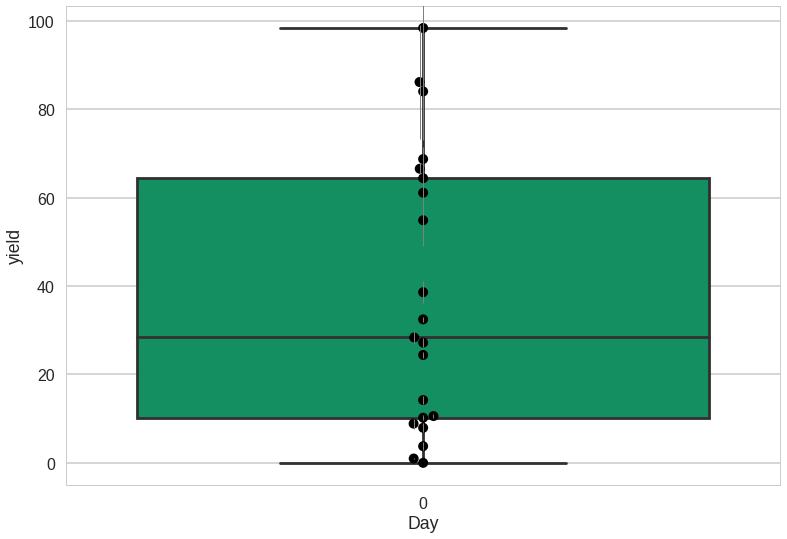

In [38]:
display_std = True # if you have included "yield_std" column in Results.csv will show it else disply 0 for std

day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = i
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

#ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#4BC15F', fliersize=0)
ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#00A368', fliersize=0)

ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    order = 0
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            std = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['std'][order]
            y_Result = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['yield'][order]
            ax.arrow(x, y-(std/2), dx=0, dy=std, linewidth=1, zorder=4, width=0, color='grey')

            order += 1

    errors = Results_m['std']

#ax.set_ylim(top=60000)
ax

In [ ]:
fig.savefig(f'#00A368_Day_{day-1}_Boxplot_TTU.png', format='png', dpi=1200)
fig.savefig(f'#00A368_Day_{day-1}_Boxplot_TTU.svg', format='svg', dpi=1200)

# Visualising Results For Each Metabolite

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

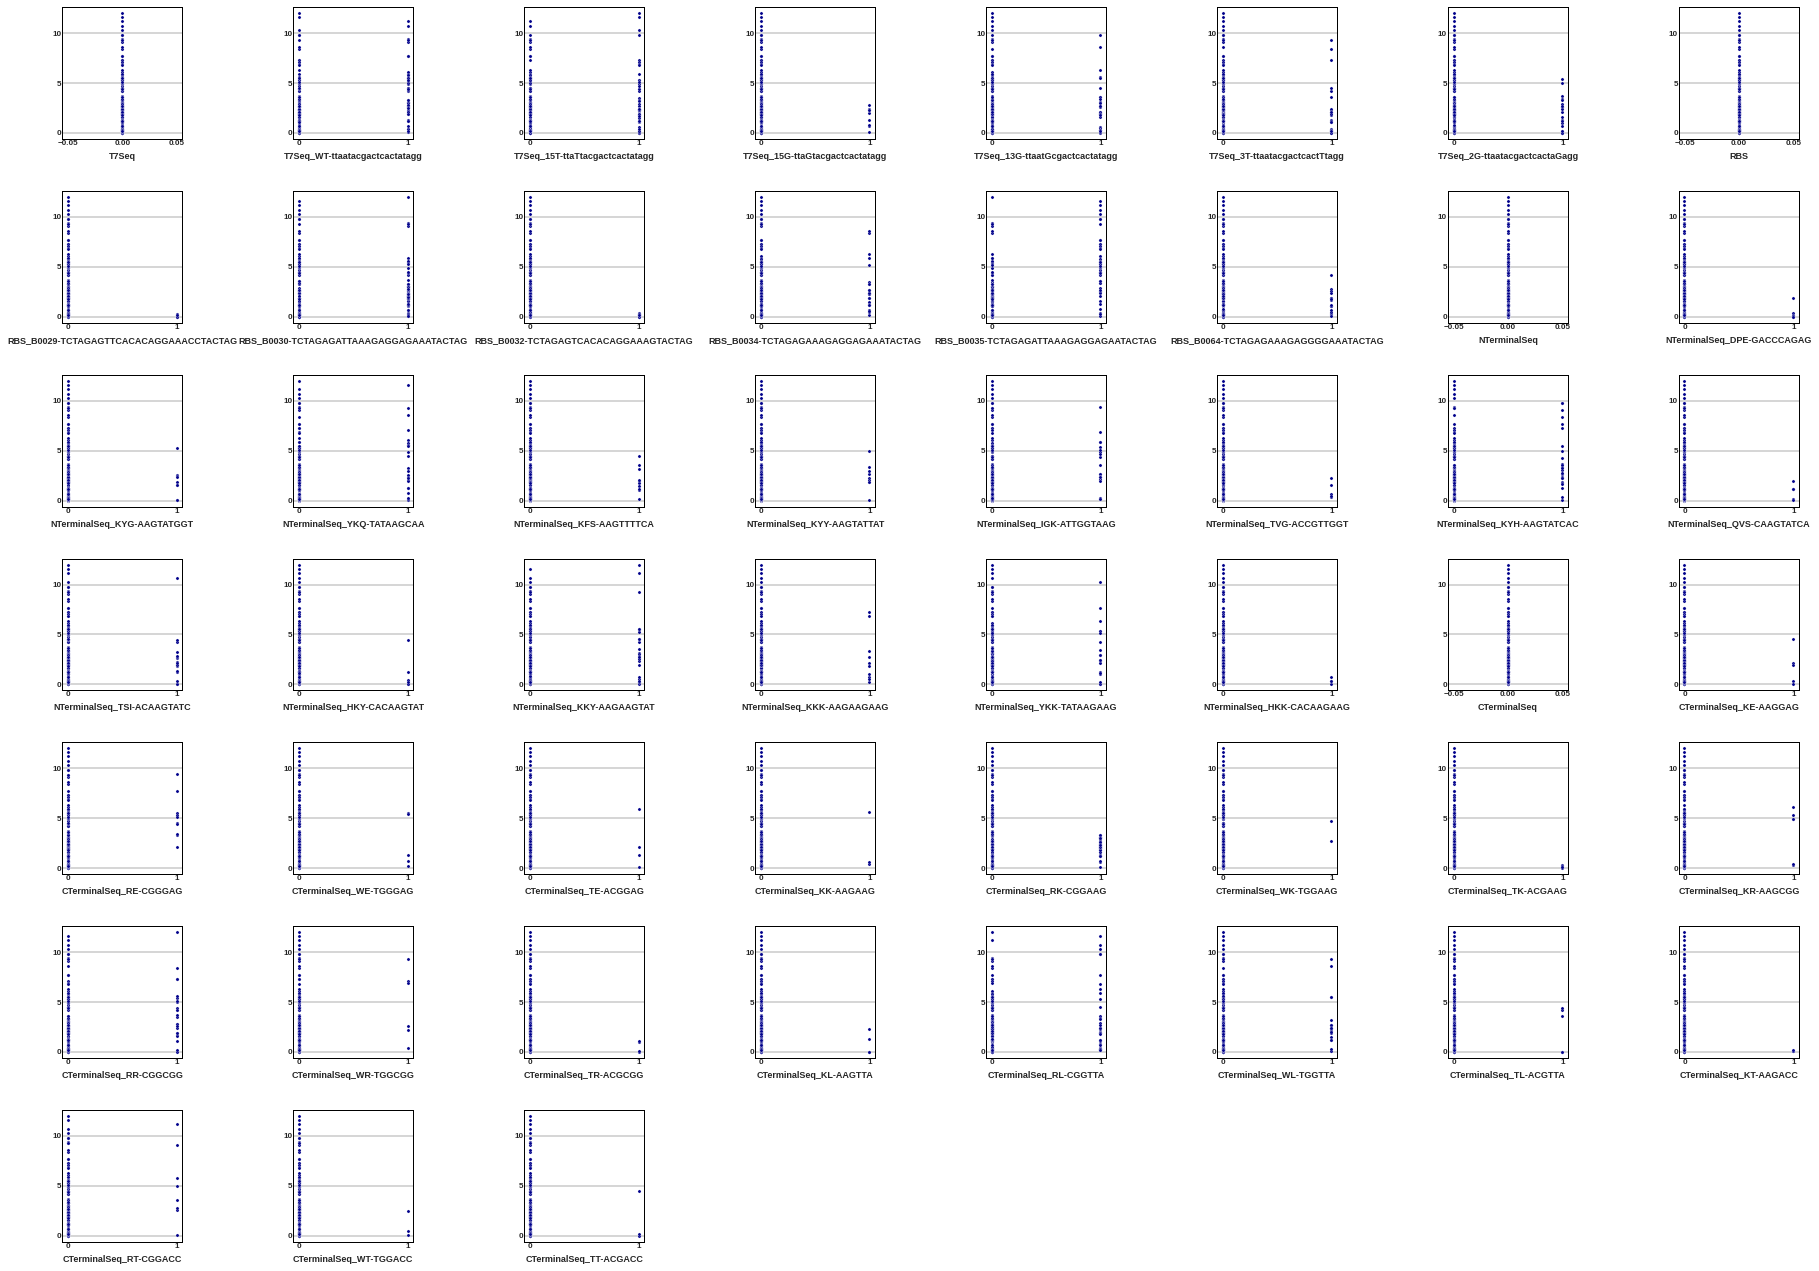

In [ ]:
desired_cols = []
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day):
    if start_day:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

plt.style.use('seaborn-whitegrid')

num = len(desired_cols)
dim = math.ceil(math.sqrt(num))
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 1.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 1.0 #set the value globally
mpl.rcParams['ytick.major.pad'] = 1.0 #set the value globally

fig = plt.figure(figsize=(25,20))

for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax.xaxis.grid(False)
    ax = sns.scatterplot(x = desired_cols[i-1], y='yield', color='darkblue', data=data, s=10)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    y_label.set_visible(False)
    #ax.xaxis.set_tick_params()
    plt.xticks(weight = 'bold', fontsize=8)
    plt.yticks(weight = 'bold', fontsize=8)

    plt.xlabel(desired_cols[i-1], labelpad=5 ,fontsize=9, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Yield.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Yield.svg', format='svg', dpi=1200)

# Visualising Results For Each Metabolite (Beta)

In [25]:
desired_cols_alternatives = []
desired_cols = []
alternative_dict = {}

day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols_alternatives += alternative_name
        alternative_dict[key] = alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols + desired_cols_alternatives)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day):
    if start_day:
        data_m, label_m, _, _= result_preprocess(num, desired_cols + desired_cols_alternatives, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols + desired_cols_alternatives, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

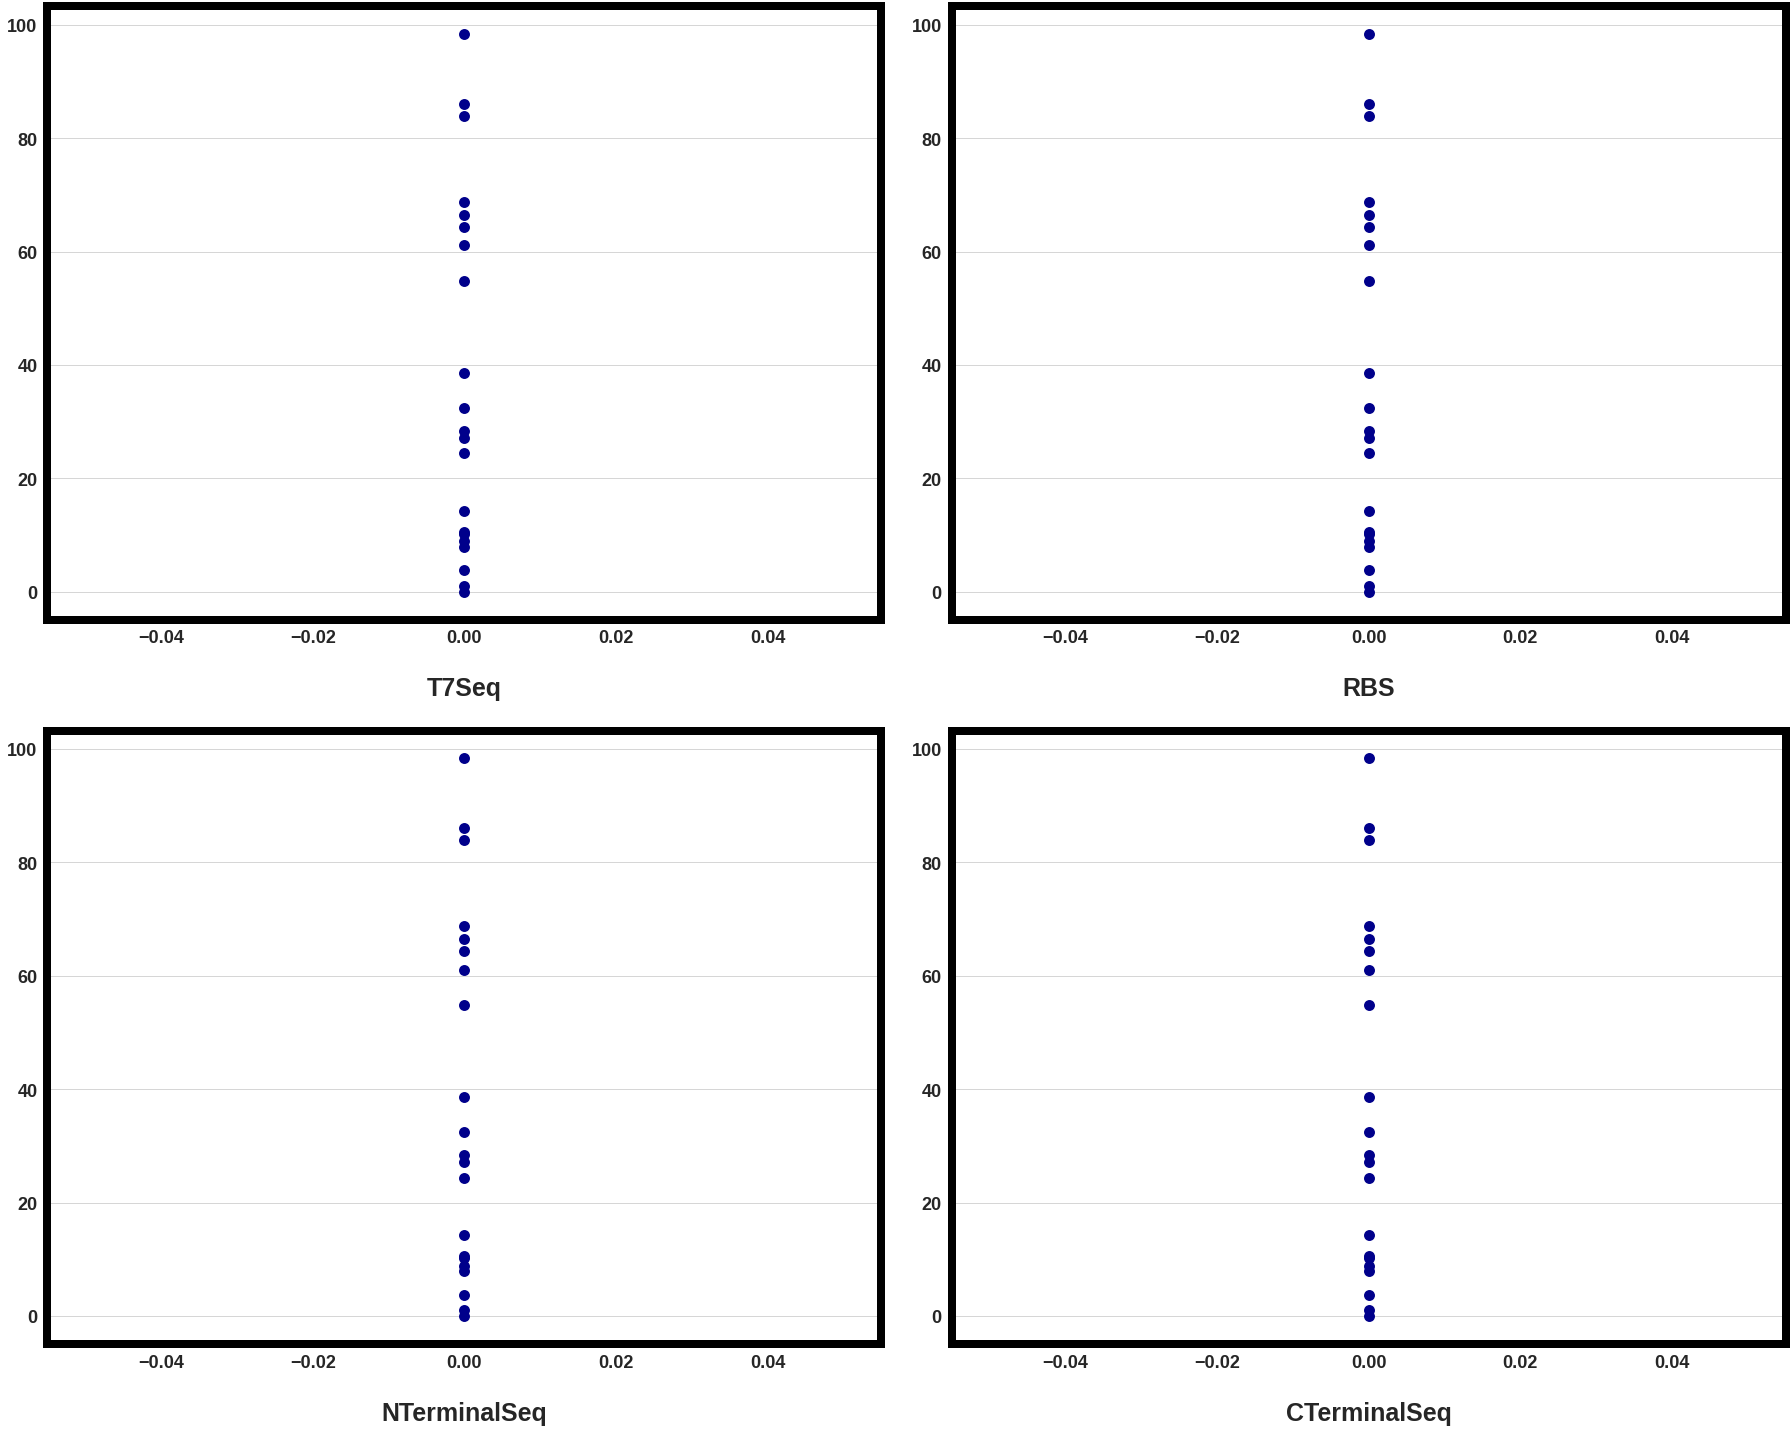

In [26]:
plt.style.use('seaborn-whitegrid')

num = len(desired_cols)
dim = math.ceil(math.sqrt(num))
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally
mpl.rcParams['ytick.major.pad'] = 10.0 #set the value globally

fig = plt.figure(figsize=(25,20))

for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax.xaxis.grid(False)
    ax = sns.scatterplot(x = desired_cols[i-1], y='yield', color='darkblue', data=data, s=120, linewidth=0)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    y_label.set_visible(False)
    #ax.xaxis.set_tick_params()
    plt.xticks(weight = 'bold', fontsize=18)
    plt.yticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Yield_NoAlternative.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Yield_NoAlternative.svg', format='svg', dpi=1200)

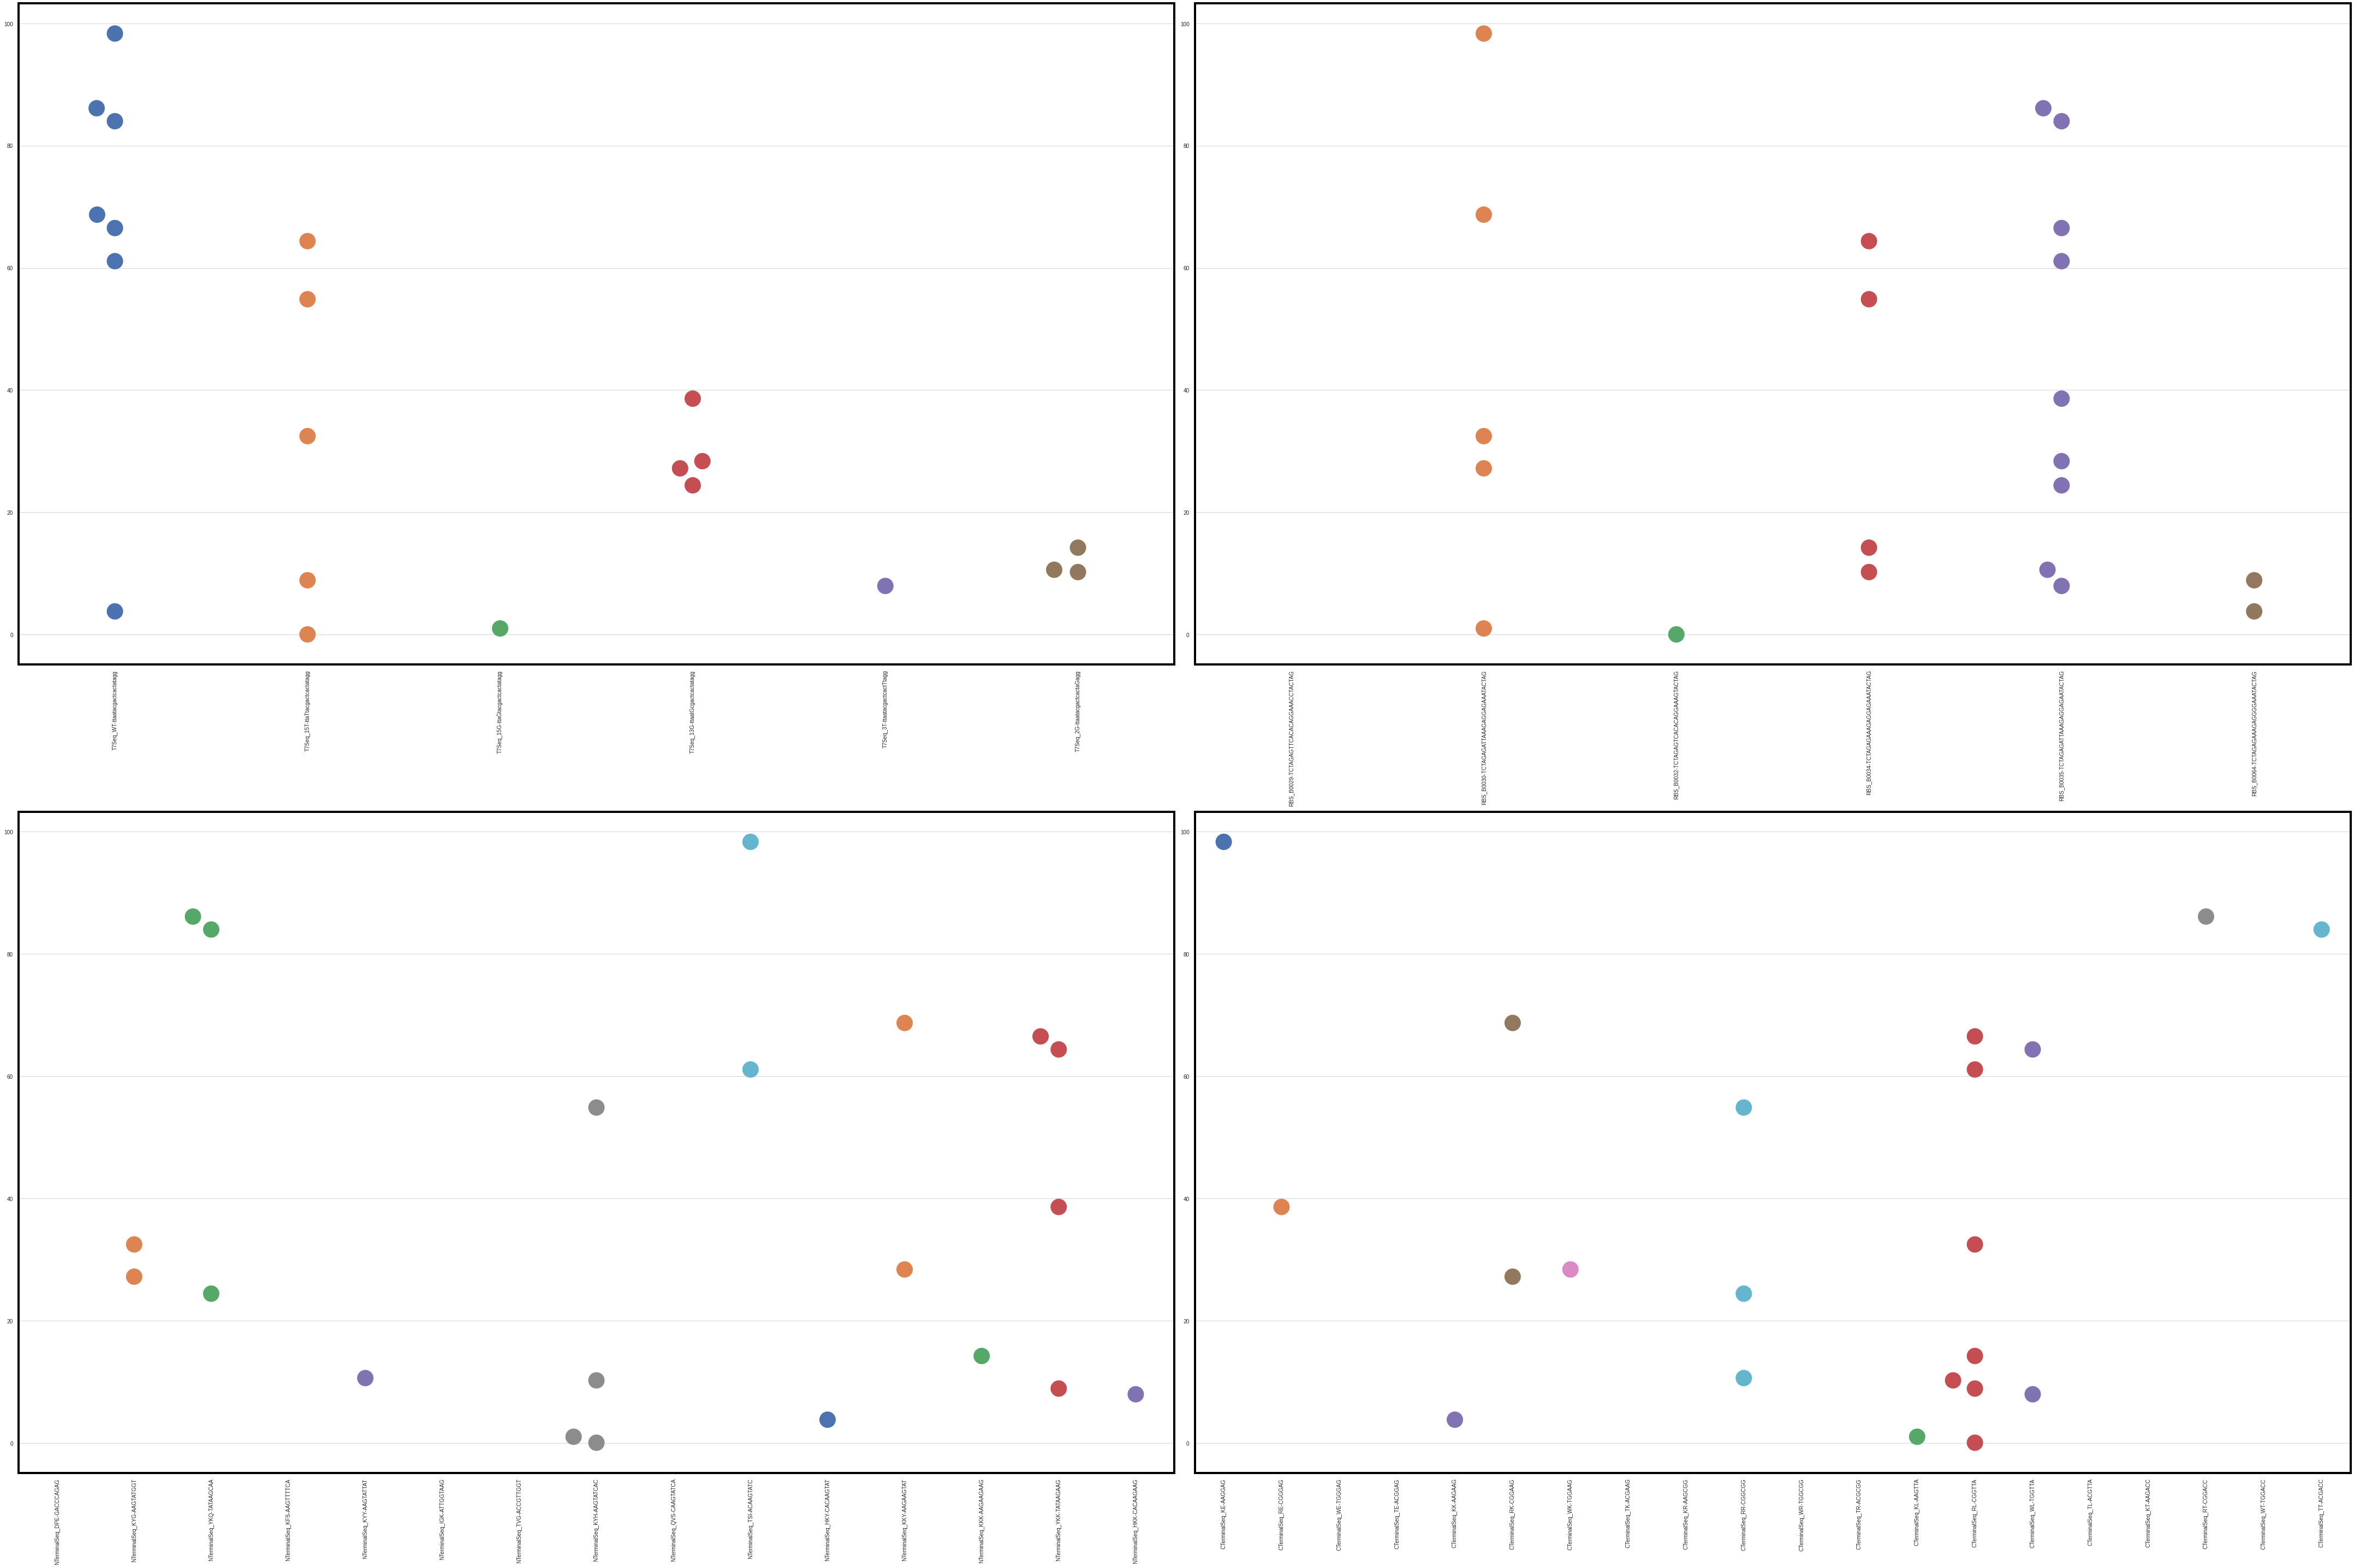

In [27]:
temp_dict = {}
for key, value in alternative_dict.items():
    temp_dict[key] = {}
    for i in value:
        temp_dict[key][i] = []
        
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)
for i in range(len(data)):
    for j in temp_dict.keys():
        for k in temp_dict[j].keys():
            if  data[desired_cols_alternatives].loc[i][k]:
                temp_dict[j][k].append(aggregated_label_m.loc[i]['yield'])

plt.style.use('seaborn-whitegrid')

num = len(temp_dict.keys())
dim = math.ceil(math.sqrt(num))

import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 4.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally
mpl.rcParams['ytick.major.pad'] = 10.0 #set the value globally

fig = plt.figure(figsize=(60,40))

for ind, main in enumerate(temp_dict.keys()):
    ax = plt.subplot(dim, dim, ind+1)
    temp_df = pd.DataFrame(columns=temp_dict[main].keys(), index=range(max([len(i) for i in temp_dict[main].values()])))
    for i in temp_dict[main].keys():
        temp_df[i].loc[0:len(temp_dict[main][i])-1] = temp_dict[main][i]

    sns.swarmplot(data=temp_df, ax=ax, size=30, palette='deep')
    plt.xticks(rotation=90)

fig.tight_layout()

In [29]:
#fig.savefig(f'Day_{day-1}_Metabolite_Yield_Alternative.png', format='png', dpi=600)
fig.savefig(f'Day_{day-1}_Metabolite_Yield_Alternative.svg', format='svg', dpi=600)

## Plot One by One

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 51.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 17.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; yo

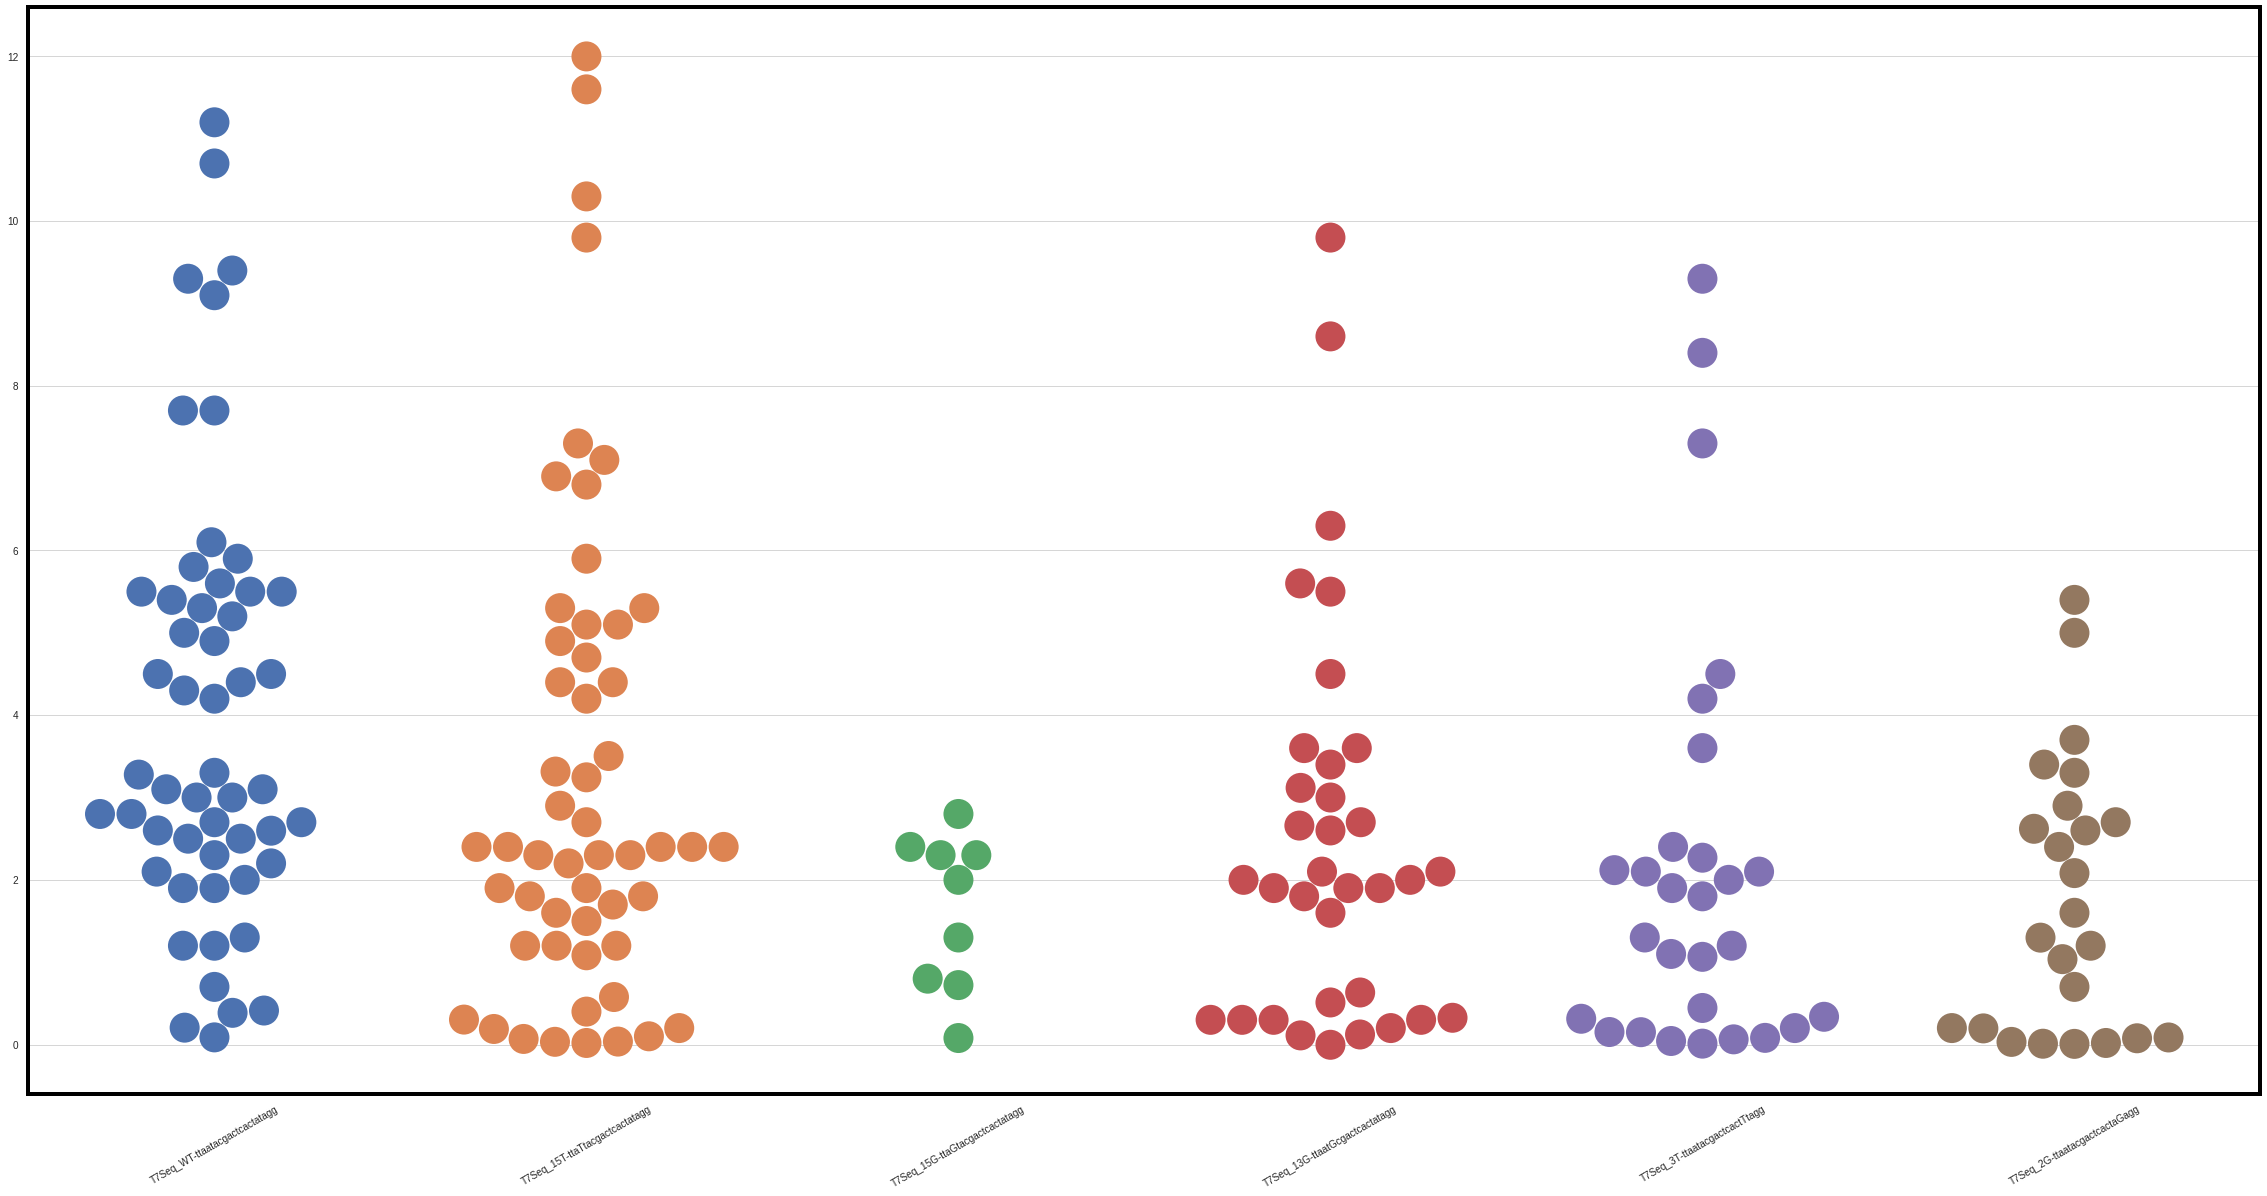

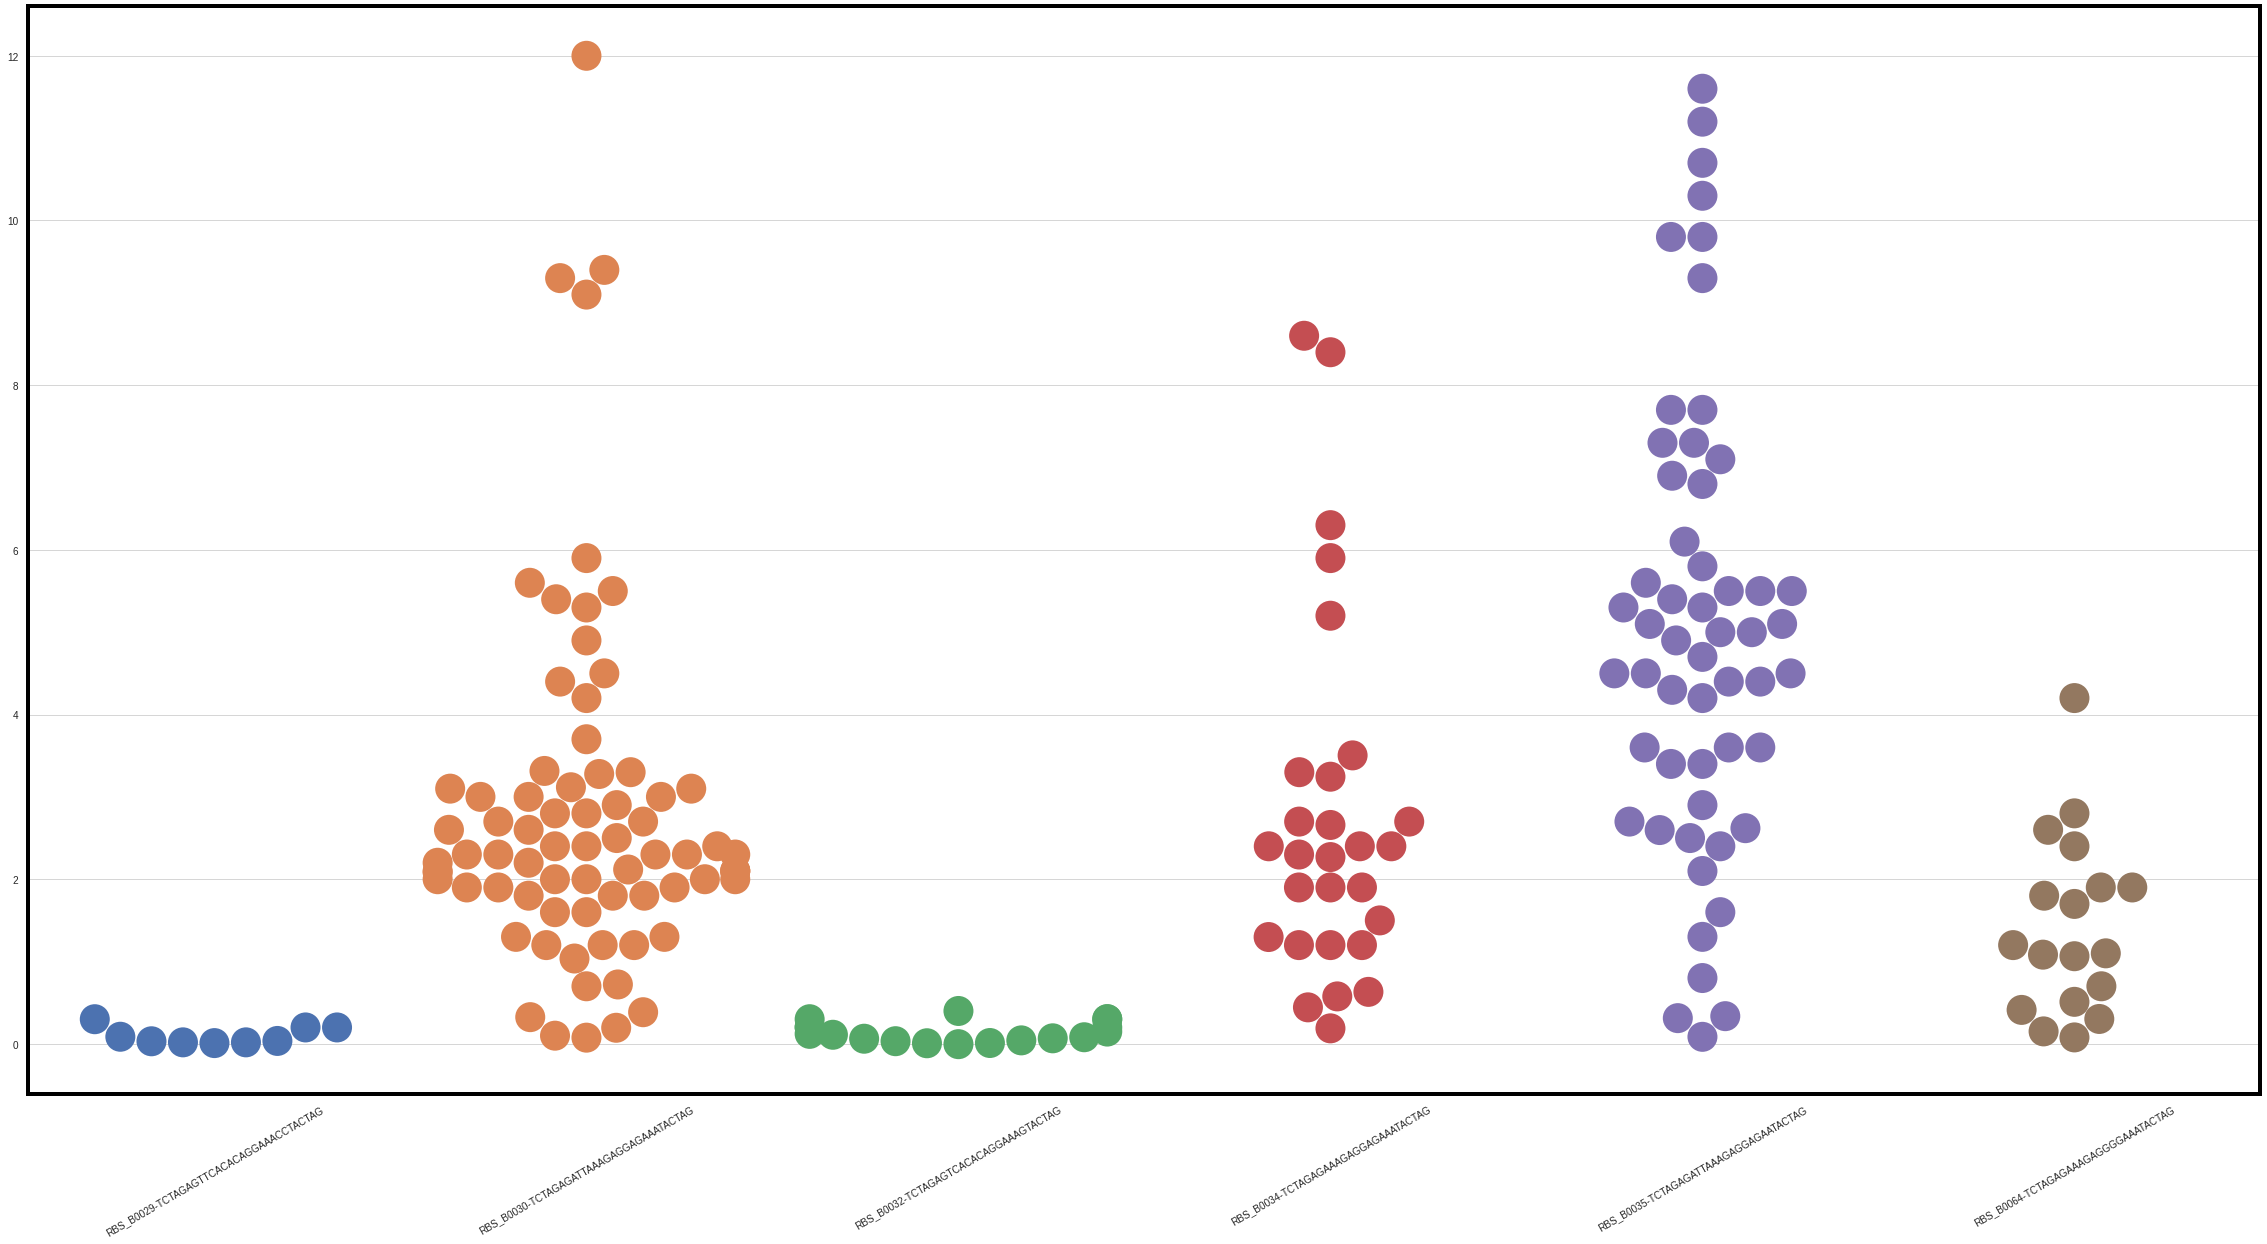

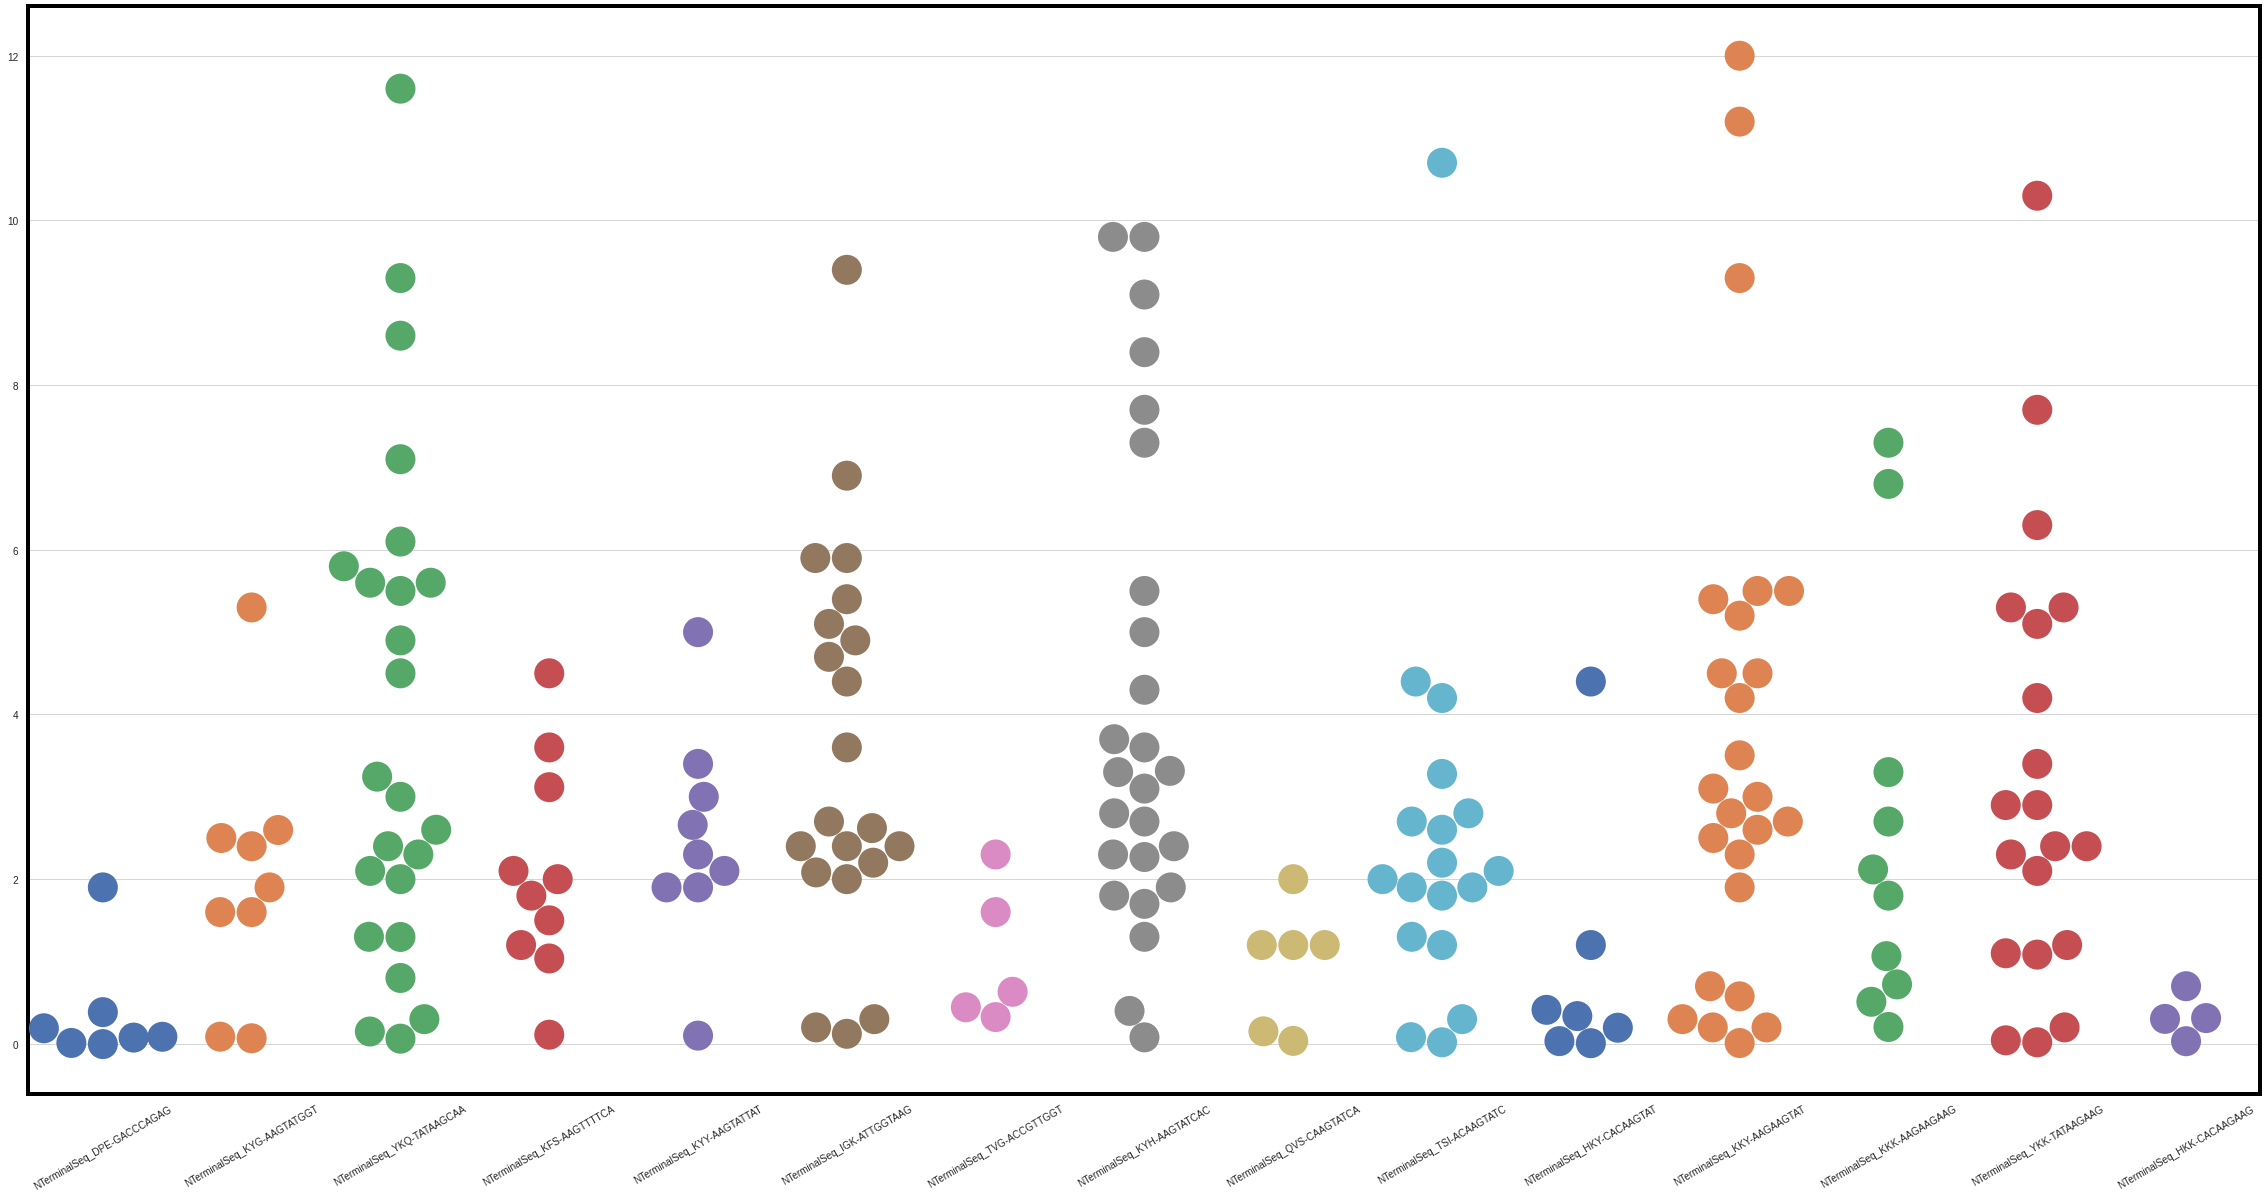

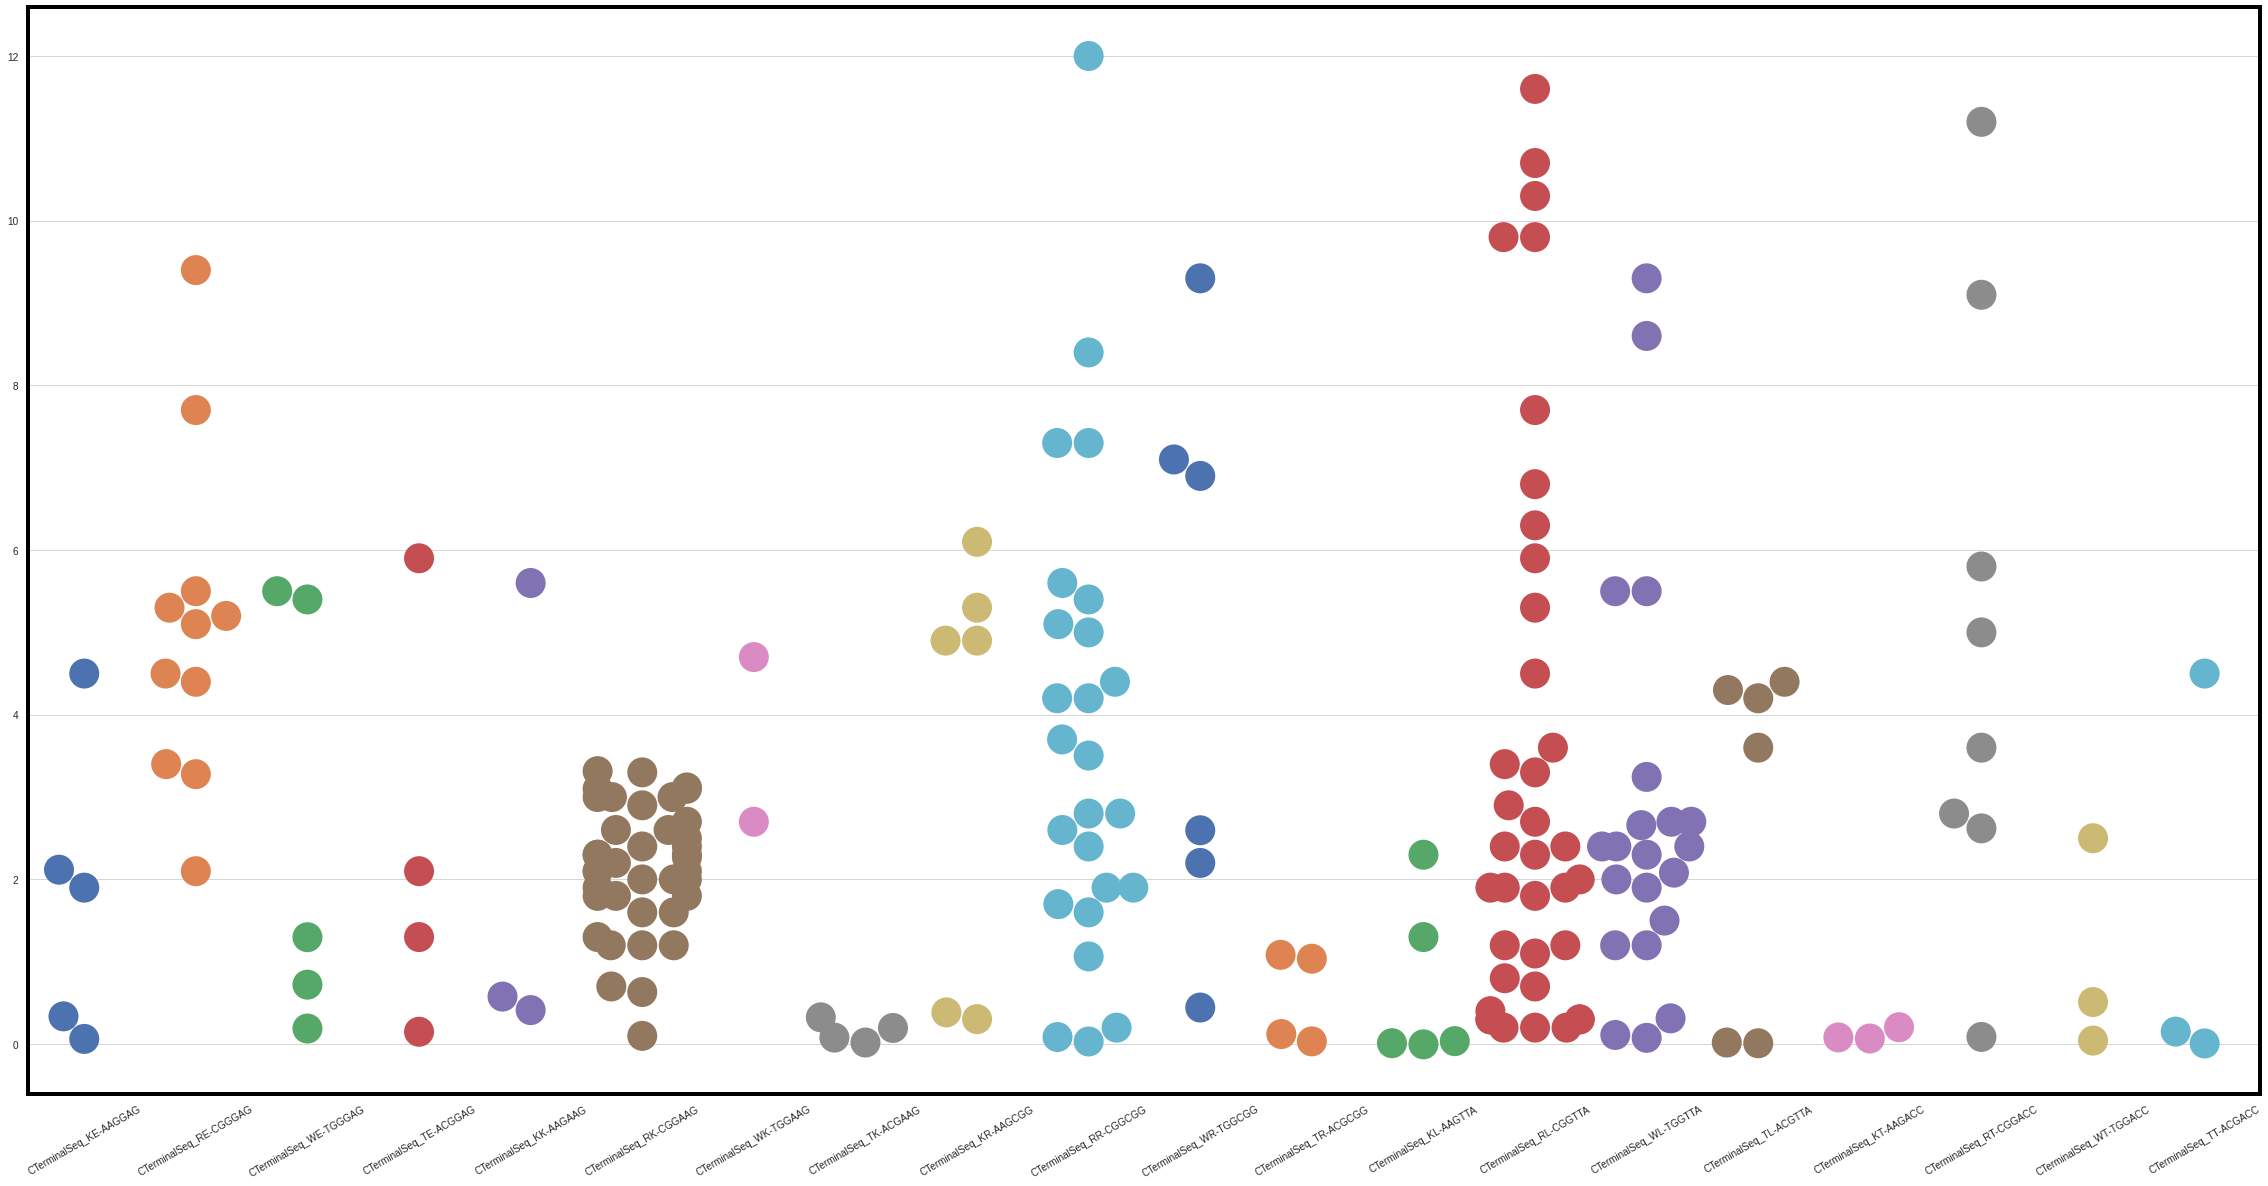

In [ ]:
temp_dict = {}
for key, value in alternative_dict.items():
    temp_dict[key] = {}
    for i in value:
        temp_dict[key][i] = []
        
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)
for i in range(len(data)):
    for j in temp_dict.keys():
        for k in temp_dict[j].keys():
            if  data[desired_cols_alternatives].loc[i][k]:
                temp_dict[j][k].append(aggregated_label_m.loc[i]['yield'])

plt.style.use('seaborn-whitegrid')

num = len(temp_dict.keys())
dim = math.ceil(math.sqrt(num))

import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 4.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally
mpl.rcParams['ytick.major.pad'] = 10.0 #set the value globally


for ind, main in enumerate(temp_dict.keys()):
    fig, ax = plt.subplots(figsize=(40,20))
    temp_df = pd.DataFrame(columns=temp_dict[main].keys(), index=range(max([len(i) for i in temp_dict[main].values()])))
    for i in temp_dict[main].keys():
        temp_df[i].loc[0:len(temp_dict[main][i])-1] = temp_dict[main][i]

    sns.swarmplot(data=temp_df, ax=ax, size=30, palette='deep')
    plt.xticks(rotation=30)
    fig.savefig(f'Day_{day-1}_Metabolite_Yield_Alternative_{main}.svg', format='svg', dpi=1200)

# Viualising Concentrations From Day_1 to Now

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

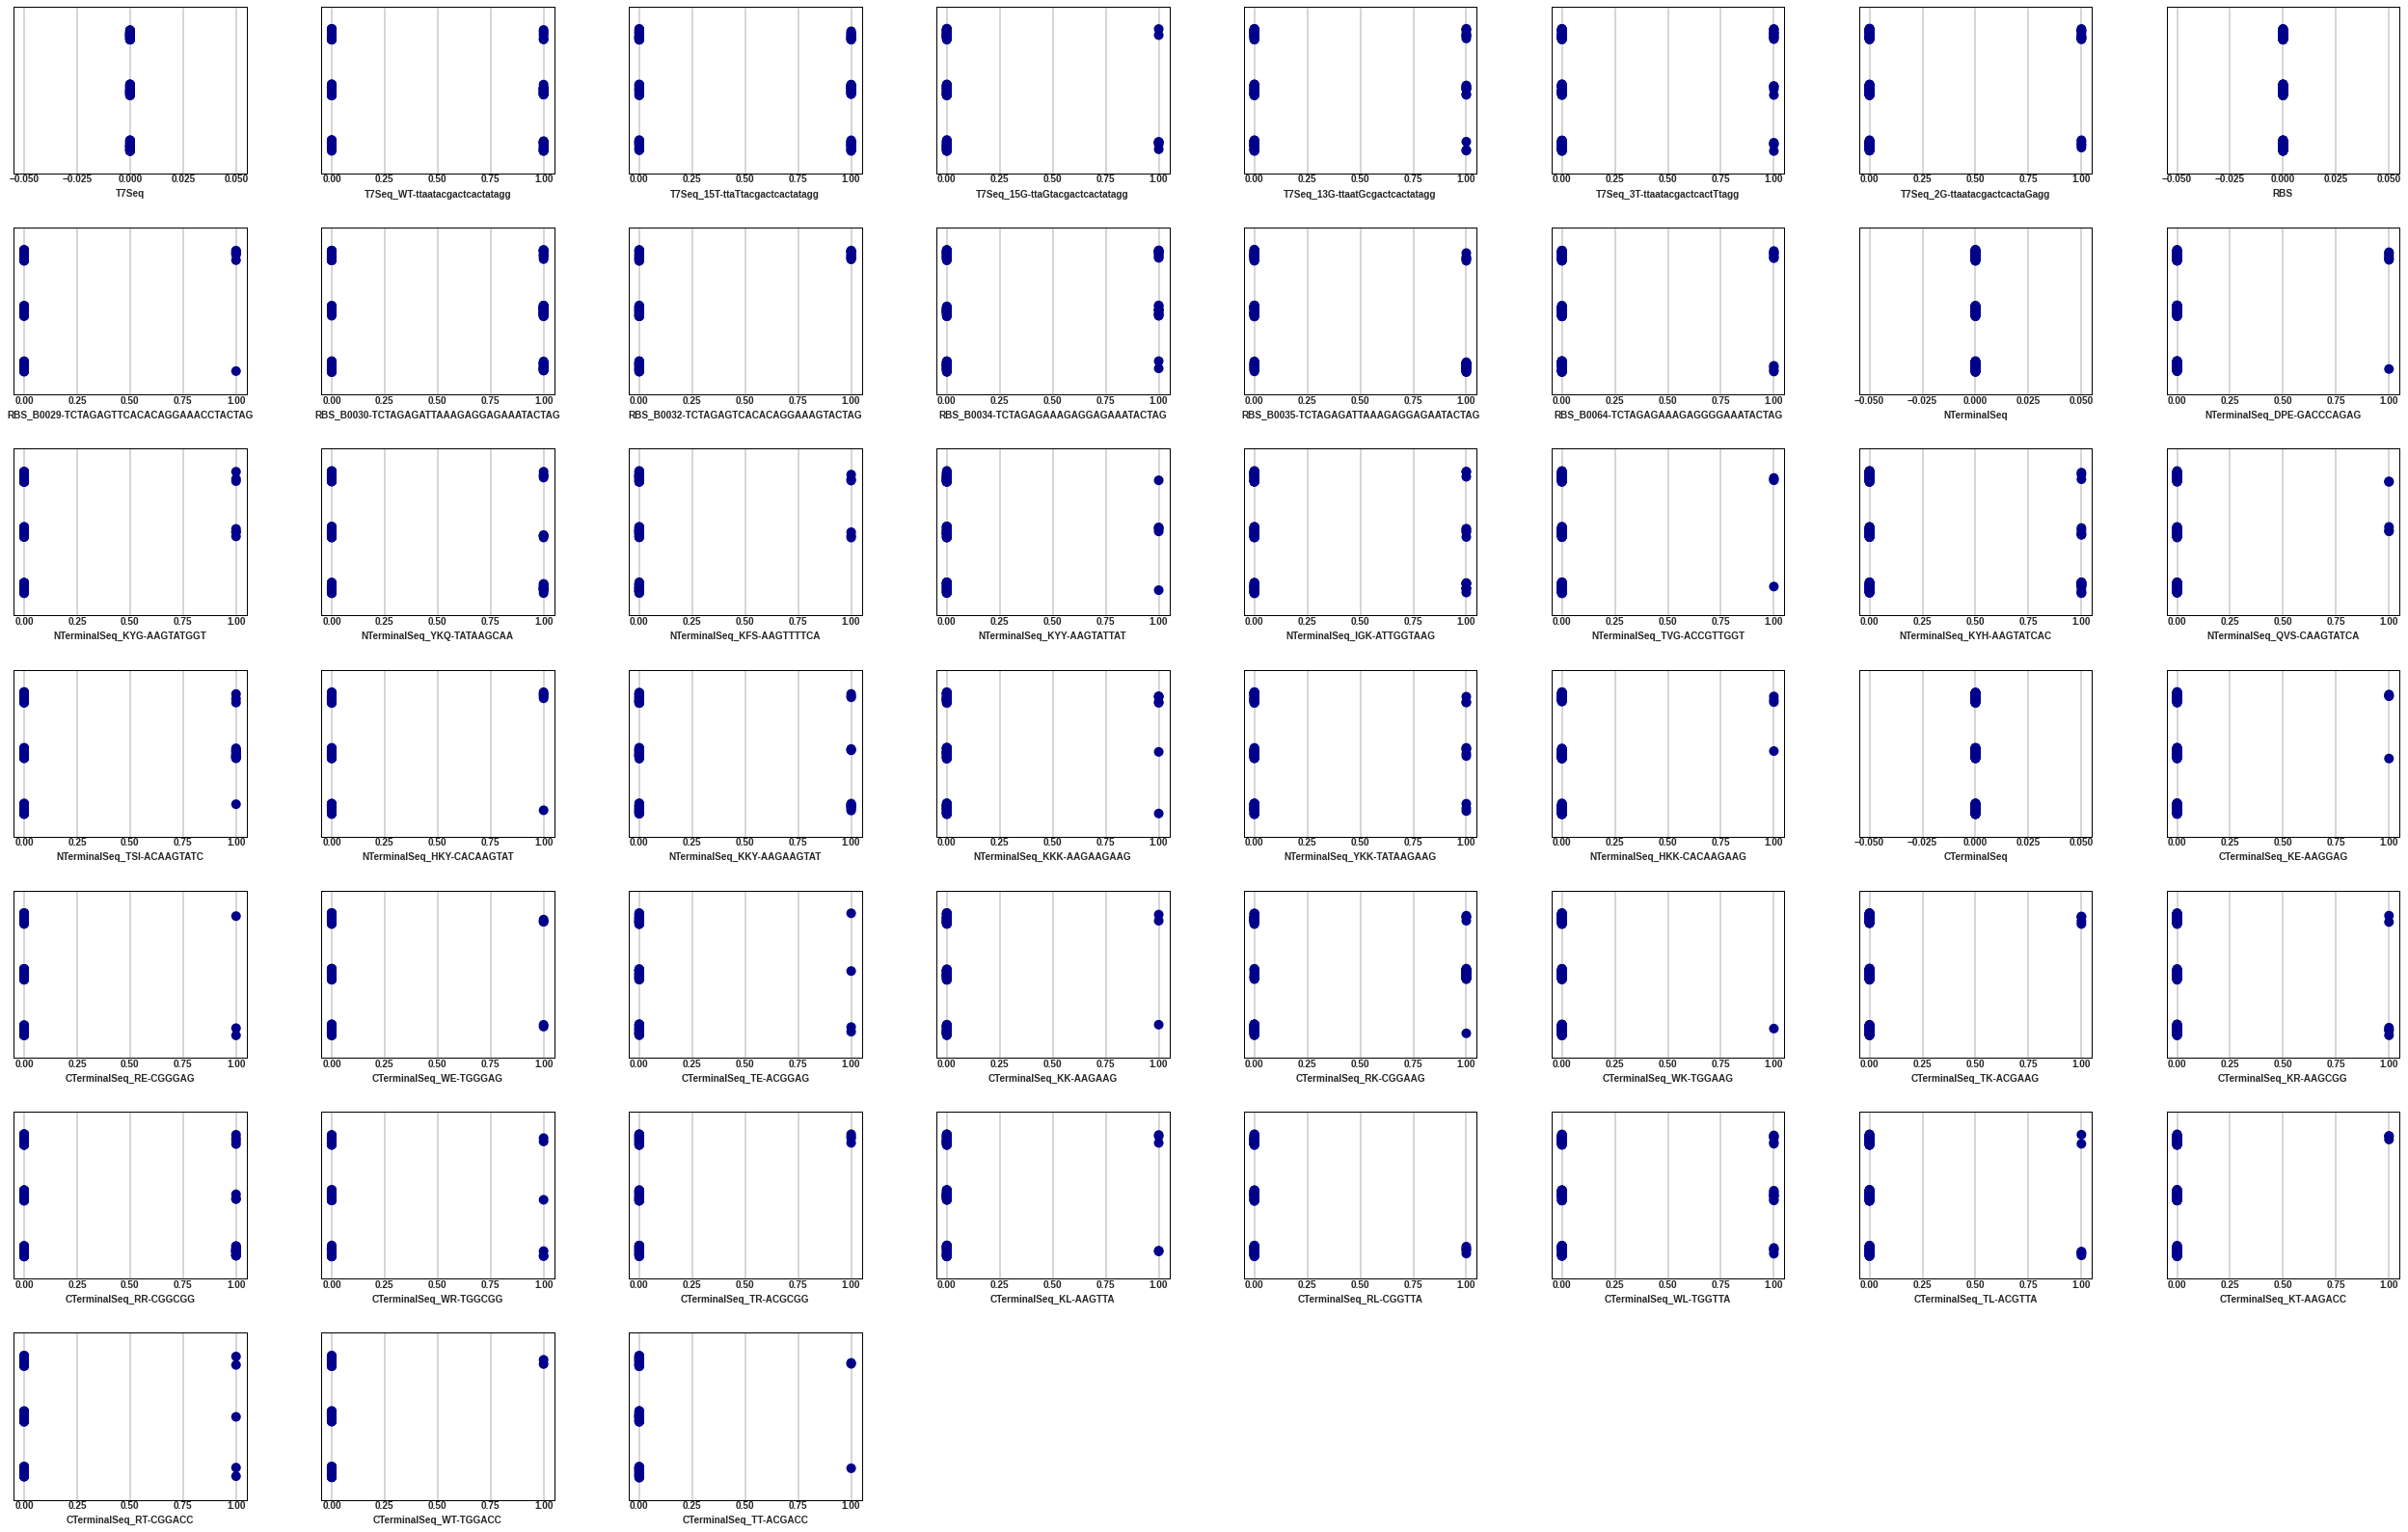

In [ ]:
data_all = pd.DataFrame(columns = list(concentrations_limits.keys())+['day'])
day = day_finder('Results')
desired_cols = []

# make column name:
desired_cols = []
for key, value in concentrations_limits.items():
    if not value['Alternatives']:
        desired_cols.append(key)
    else:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name

final_order = desired_cols

d = (1, 0)[os.path.isfile('Results_0.csv')]

while os.path.exists(f'Results_{d}.csv'):
    data = pd.read_csv(f'Results_{d}.csv')
    data = data[desired_cols]
    data = data.iloc[:days_range[d-1],:]
    data['day'] = f'Day_{d}'
    data_all = pd.concat([data_all, data]).reset_index(drop=True)
    d += 1

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 1.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 1.0 #set the value globally


num = len(desired_cols)
dim = math.ceil(math.sqrt(num))

fig = plt.figure(figsize=(35,25))
for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax = sns.stripplot(x=desired_cols[i-1], y="day", color='darkblue', data=data_all, s=10)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    y_label.set_visible(False)

    ax.yaxis.set_ticklabels([])
    plt.xticks(weight = 'bold', fontsize=10)

    plt.xlabel(desired_cols[i-1], labelpad=5 ,fontsize=10, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
#fig.savefig(f'Day_{day-1}_Metabolite_Days.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Days.svg', format='svg', dpi=1200)

# Transform Volumes.csv to Table2Speech Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Table2Speech_Volumes_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,Type_4,Type_4,Type_4,Type_4,Type_2,Type_2,Type_2,Type_2,Type_1,Type_1,Type_1,Type_1,Type_3,Type_3,Type_3,Type_3,Type_1,Type_1,Type_1,Type_1,Type_3,Type_3,Type_3,Type_3,Type_2,Type_2,Type_2,Type_2,Type_4,Type_4,Type_4,Type_4,Type_3,Type_3,Type_3,Type_3,Type_4,Type_4,Type_4,Type_4,Type_2,Type_2,Type_2,Type_2,Type_1,Type_1,Type_1,Type_1,Type_2,Type_2,Type_2,Type_2,Type_4,Type_4,Type_4,Type_4,Type_3,Type_3,Type_3,Type_3,Type_1,Type_1,Type_1,Type_1,PlasmidCopyNumber,PUREratio,water
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.9,-2.9
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.8,-1.8
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.9,-0.9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.9,-0.9
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.9,-1.9
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,-0.7
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.9,-0.9
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,-0.7
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.9,-1.9
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.9,-2.9


In [ ]:
data.to_csv(f'Table2Speech_Volumes_{which_day}.csv', index=False)

# Transform Volumes.csv to ECHO liquid Handler Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Echo_Input_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder
plate_384_well = True
triplicate = False

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0


In [ ]:
intermediate = put_volumes_to_384_wells(data, starting_well='A1', vertical=False, make_csv=False)
intermediate[1]

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water,well_name
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A1
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0,A2
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0,A3
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0,A4
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0,A5
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A6
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0,A7
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0,A8
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0,A9
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0,A10


In [ ]:
intermediate[0]['pTHS']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
A,0.0,0.0,200.0,0.0,0.0,0.0,0.0,200.0,200.0,0.0,0.0,200.0,200.0,200.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
echo_input = source_to_destination(intermediate[1], desired_order=None, reset_index=True, check_zero=False)
echo_input[1]

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
...,...,...,...,...,...
295,Plate1,water well,destPlate1,A16,3550.0
296,Plate1,water well,destPlate1,A17,2850.0
297,Plate1,water well,destPlate1,A18,4300.0
298,Plate1,water well,destPlate1,A19,1200.0


In [ ]:
echo_input[1].to_csv(f'Echo_Input_{which_day}.csv', index=False)

In [ ]:
echo_input[0]['PEG']

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
5,Plate1,PEG well,destPlate1,A6,800.0
6,Plate1,PEG well,destPlate1,A7,1400.0
7,Plate1,PEG well,destPlate1,A8,1000.0
8,Plate1,PEG well,destPlate1,A9,600.0
9,Plate1,PEG well,destPlate1,A10,1400.0


# Find K Most Informative Combinations

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* specify in "k" i.e. how many Combinations you want to get 
* run all other cells!
* you can download K_Most_Informative_Combinations.csv file from Files that contain index of most informative combinations for 5 iterations</p1>

In [ ]:
k = 20
number_try = 2000

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

,T7Seq,T7Seq_WT-ttaatacgactcactatagg,T7Seq_15T-ttaTtacgactcactatagg,T7Seq_15G-ttaGtacgactcactatagg,T7Seq_13G-ttaatGcgactcactatagg,T7Seq_3T-ttaatacgactcactTtagg,T7Seq_2G-ttaatacgactcactaGagg,RBS,RBS_B0029-TCTAGAGTTCACACAGGAAACCTACTAG,RBS_B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,RBS_B0032-TCTAGAGTCACACAGGAAAGTACTAG,RBS_B0034-TCTAGAGAAAGAGGAGAAATACTAG,RBS_B0035-TCTAGAGATTAAAGAGGAGAATACTAG,RBS_B0064-TCTAGAGAAAGAGGGGAAATACTAG,NTerminalSeq,NTerminalSeq_DPE-GACCCAGAG,NTerminalSeq_KYG-AAGTATGGT,NTerminalSeq_YKQ-TATAAGCAA,NTerminalSeq_KFS-AAGTTTTCA,NTerminalSeq_KYY-AAGTATTAT,NTerminalSeq_IGK-ATTGGTAAG,NTerminalSeq_TVG-ACCGTTGGT,NTerminalSeq_KYH-AAGTATCAC,NTerminalSeq_QVS-CAAGTATCA,NTerminalSeq_TSI-ACAAGTATC,NTerminalSeq_HKY-CACAAGTAT,NTerminalSeq_KKY-AAGAAGTAT,NTerminalSeq_KKK-AAGAAGAAG,NTerminalSeq_YKK-TATAAGAAG,NTerminalSeq_HKK-CACAAGAAG,CTerminalSeq,CTerminalSeq_KE-AAGGAG,CTerminalSeq_RE-CGGGAG,CTerminalSeq_WE-TGGGAG,CTerminalSeq_TE-ACGGAG,CTerminalSeq_KK-AAGAAG,CTerminalSeq_RK-CGGAAG,CTerminalSeq_WK-TGGAAG,CTerminalSeq_TK-ACGAAG,CTerminalSeq_KR-AAGCGG,CTerminalSeq_RR-CGGCGG,CTerminalSeq_WR-TGGCGG,CTerminalSeq_TR-ACGCGG,CTerminalSeq_KL-AAGTTA,CTerminalSeq_RL-CGGTTA,CTerminalSeq_WL-TGGTTA,CTerminalSeq_TL-ACGTTA,CTerminalSeq_KT-AAGACC,CTerminalSeq_RT-CGGACC,CTerminalSeq_WT-TGGACC,CTerminalSeq_TT-ACGACC
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
196,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
197,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
198,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create the grid search parameter grid and scoring funcitons
param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

model = XGBRegressor(objective = 'reg:squarederror')
# create the grid search object
grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
print('RandomSearchCV ...')
grid.fit(aggregated_data_m.values, aggregated_label_m.values)
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
print('RandomSearchCV Done!')

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
indexs = []
num = 0
while num < number_try:
    numbers = set()
    while len(numbers) < k:
        numbers.add(random.randint(0, len(aggregated_data_m)-1))
    indexs.append(numbers)
    num += 1

In [ ]:
performance = []
best_param = results.params.iloc[0,]
all_set = set(range(len(aggregated_data_m)))
counter = 0
for index in indexs:
    counter += 1
    if counter%100 == 0:print(counter)
    index_test = all_set - index
    index_test = list(index_test)
    index = list(index)
    model = XGBRegressor(objective = 'reg:squarederror', **best_param)
    model.fit(aggregated_data_m.iloc[index].values, aggregated_label_m.iloc[index].values)
    performance.append(spearmanr(model.predict(aggregated_data_m.iloc[index_test].values), aggregated_label_m.iloc[index_test].values).correlation**2)

performance = np.array(performance)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
number_to_select = 5
ind = np.argpartition(performance, -number_to_select)[-number_to_select:]
performance[ind]

array([0.46853408, 0.48120947, 0.49734211, 0.49342201, 0.48599123])

In [ ]:
np.array(indexs)[ind]

array([{159, 134, 199, 40, 167, 170, 79, 145, 146, 179, 148, 85, 51, 184, 185, 90, 187, 29, 95, 127},
       {96, 4, 71, 136, 42, 139, 28, 142, 127, 176, 49, 145, 147, 31, 79, 23, 89, 90, 156, 191},
       {192, 162, 131, 196, 66, 103, 73, 10, 106, 45, 114, 84, 149, 119, 95, 58, 155, 93, 190, 191},
       {128, 33, 162, 35, 36, 66, 167, 40, 105, 170, 75, 71, 73, 175, 176, 111, 83, 86, 25, 29},
       {191, 33, 134, 40, 170, 11, 74, 45, 110, 111, 49, 181, 21, 95, 54, 117, 92, 189, 158, 159}],
      dtype=object)

In [ ]:
pd.DataFrame(np.array(indexs)[ind]).to_csv('K_Most_Informative_Combinations.csv', index=False)

# Find Feature Importances


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download importance_df.csv  from Files</p1>

In [ ]:
n_iter = 200

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

In [ ]:
importance_list = []
print('This may takes minutes!')

for day_i in range(1, day+1):
    aggregated_data_m = pd.DataFrame(columns=desired_cols)
    aggregated_label_m = pd.DataFrame(columns=['yield'])

    for num in range(start_day, day_i + 1):
        if start_day or num>0:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
        else:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

        aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
        aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # creat estimator
    model = XGBRegressor(objective = 'reg:squarederror')

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...', day_i)
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    print('RandomSearchCV Done!')

    model = XGBRegressor(objective = 'reg:squarederror', **results.params.iloc[0,])
    model.fit(aggregated_data_m.values, aggregated_label_m.values)
    importance_list.append(model.feature_importances_)

This may takes minutes!
RandomSearchCV ... 1
RandomSearchCV Done!
RandomSearchCV ... 2
RandomSearchCV Done!
RandomSearchCV ... 3
RandomSearchCV Done!
RandomSearchCV ... 4
RandomSearchCV Done!


In [ ]:
importance_df = pd.DataFrame(importance_list, columns=aggregated_data_m.columns)
importance_df

,T7Seq,T7Seq_WT-ttaatacgactcactatagg,T7Seq_15T-ttaTtacgactcactatagg,T7Seq_15G-ttaGtacgactcactatagg,T7Seq_13G-ttaatGcgactcactatagg,T7Seq_3T-ttaatacgactcactTtagg,T7Seq_2G-ttaatacgactcactaGagg,RBS,RBS_B0029-TCTAGAGTTCACACAGGAAACCTACTAG,RBS_B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,RBS_B0032-TCTAGAGTCACACAGGAAAGTACTAG,RBS_B0034-TCTAGAGAAAGAGGAGAAATACTAG,RBS_B0035-TCTAGAGATTAAAGAGGAGAATACTAG,RBS_B0064-TCTAGAGAAAGAGGGGAAATACTAG,NTerminalSeq,NTerminalSeq_DPE-GACCCAGAG,NTerminalSeq_KYG-AAGTATGGT,NTerminalSeq_YKQ-TATAAGCAA,NTerminalSeq_KFS-AAGTTTTCA,NTerminalSeq_KYY-AAGTATTAT,NTerminalSeq_IGK-ATTGGTAAG,NTerminalSeq_TVG-ACCGTTGGT,NTerminalSeq_KYH-AAGTATCAC,NTerminalSeq_QVS-CAAGTATCA,NTerminalSeq_TSI-ACAAGTATC,NTerminalSeq_HKY-CACAAGTAT,NTerminalSeq_KKY-AAGAAGTAT,NTerminalSeq_KKK-AAGAAGAAG,NTerminalSeq_YKK-TATAAGAAG,NTerminalSeq_HKK-CACAAGAAG,CTerminalSeq,CTerminalSeq_KE-AAGGAG,CTerminalSeq_RE-CGGGAG,CTerminalSeq_WE-TGGGAG,CTerminalSeq_TE-ACGGAG,CTerminalSeq_KK-AAGAAG,CTerminalSeq_RK-CGGAAG,CTerminalSeq_WK-TGGAAG,CTerminalSeq_TK-ACGAAG,CTerminalSeq_KR-AAGCGG,CTerminalSeq_RR-CGGCGG,CTerminalSeq_WR-TGGCGG,CTerminalSeq_TR-ACGCGG,CTerminalSeq_KL-AAGTTA,CTerminalSeq_RL-CGGTTA,CTerminalSeq_WL-TGGTTA,CTerminalSeq_TL-ACGTTA,CTerminalSeq_KT-AAGACC,CTerminalSeq_RT-CGGACC,CTerminalSeq_WT-TGGACC,CTerminalSeq_TT-ACGACC
0,0.0,0.000000,0.034925,0.014583,0.015683,0.022979,0.020864,0.0,0.082425,0.011257,0.084741,0.040110,0.019927,0.077536,0.0,0.048276,0.011437,0.000000,0.000000,0.000000,0.022171,0.036215,0.000000,0.027507,0.000000,0.061467,0.000000,0.024026,0.000000,0.042718,0.0,0.000000,0.032466,0.033,0.000000,0.028815,0.047694,0.0,0.051862,0.045766,0.000000,0.024561,0.015324,0.000000,0.000000,0.011466,0.000000,0.0,0.010198,0.0,0.0
1,0.0,0.038393,0.010576,0.000000,0.011726,0.018542,0.022160,0.0,0.052489,0.062386,0.234028,0.085016,0.012265,0.104670,0.0,0.047790,0.006217,0.011839,0.012457,0.016344,0.013907,0.000000,0.012940,0.020125,0.009310,0.038951,0.011473,0.009332,0.008278,0.025778,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.041828,0.0,0.019657,0.000000,0.021162,0.000000,0.000000,0.000000,0.000000,0.020361,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.026289,0.026555,0.017135,0.010045,0.010499,0.018509,0.0,0.030339,0.033261,0.065907,0.017680,0.103296,0.015541,0.0,0.027763,0.008734,0.036944,0.000000,0.000000,0.016945,0.020344,0.031454,0.000000,0.028601,0.052143,0.026749,0.000000,0.008083,0.025019,0.0,0.012526,0.000000,0.000,0.016185,0.000000,0.022539,0.0,0.000000,0.000000,0.029966,0.060595,0.000000,0.010315,0.138140,0.014389,0.012325,0.0,0.025186,0.0,0.0
3,0.0,0.042574,0.016834,0.047165,0.014247,0.037503,0.037879,0.0,0.029955,0.036707,0.066332,0.040130,0.181195,0.023583,0.0,0.053740,0.000000,0.028192,0.000000,0.010354,0.029840,0.020249,0.032155,0.000000,0.017445,0.000000,0.042499,0.000000,0.004748,0.021446,0.0,0.000000,0.023324,0.000,0.000000,0.000000,0.017412,0.0,0.000000,0.000000,0.032173,0.000000,0.000000,0.000000,0.025369,0.016920,0.026245,0.0,0.023786,0.0,0.0


In [ ]:
importance_df.to_csv('importance_df.csv', index=False)

* find feature importance through 
sklearn.feature_selection.mutual_info_regression

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(aggregated_data_m.values)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(aggregated_label_m.values)

In [ ]:
importance_df_sklearn = pd.DataFrame(mutual_info_regression(X, y)).T
importance_df_sklearn.columns = aggregated_data_m.columns
importance_df_sklearn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,T7Seq,T7Seq_WT-ttaatacgactcactatagg,T7Seq_15T-ttaTtacgactcactatagg,T7Seq_15G-ttaGtacgactcactatagg,T7Seq_13G-ttaatGcgactcactatagg,T7Seq_3T-ttaatacgactcactTtagg,T7Seq_2G-ttaatacgactcactaGagg,RBS,RBS_B0029-TCTAGAGTTCACACAGGAAACCTACTAG,RBS_B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,RBS_B0032-TCTAGAGTCACACAGGAAAGTACTAG,RBS_B0034-TCTAGAGAAAGAGGAGAAATACTAG,RBS_B0035-TCTAGAGATTAAAGAGGAGAATACTAG,RBS_B0064-TCTAGAGAAAGAGGGGAAATACTAG,NTerminalSeq,NTerminalSeq_DPE-GACCCAGAG,NTerminalSeq_KYG-AAGTATGGT,NTerminalSeq_YKQ-TATAAGCAA,NTerminalSeq_KFS-AAGTTTTCA,NTerminalSeq_KYY-AAGTATTAT,NTerminalSeq_IGK-ATTGGTAAG,NTerminalSeq_TVG-ACCGTTGGT,NTerminalSeq_KYH-AAGTATCAC,NTerminalSeq_QVS-CAAGTATCA,NTerminalSeq_TSI-ACAAGTATC,NTerminalSeq_HKY-CACAAGTAT,NTerminalSeq_KKY-AAGAAGTAT,NTerminalSeq_KKK-AAGAAGAAG,NTerminalSeq_YKK-TATAAGAAG,NTerminalSeq_HKK-CACAAGAAG,CTerminalSeq,CTerminalSeq_KE-AAGGAG,CTerminalSeq_RE-CGGGAG,CTerminalSeq_WE-TGGGAG,CTerminalSeq_TE-ACGGAG,CTerminalSeq_KK-AAGAAG,CTerminalSeq_RK-CGGAAG,CTerminalSeq_WK-TGGAAG,CTerminalSeq_TK-ACGAAG,CTerminalSeq_KR-AAGCGG,CTerminalSeq_RR-CGGCGG,CTerminalSeq_WR-TGGCGG,CTerminalSeq_TR-ACGCGG,CTerminalSeq_KL-AAGTTA,CTerminalSeq_RL-CGGTTA,CTerminalSeq_WL-TGGTTA,CTerminalSeq_TL-ACGTTA,CTerminalSeq_KT-AAGACC,CTerminalSeq_RT-CGGACC,CTerminalSeq_WT-TGGACC,CTerminalSeq_TT-ACGACC
0,0.016675,0.039459,0.041335,0.026654,0.033514,0.0,0.009292,0.006571,0.063791,0.05507,0.140403,0.01726,0.172045,0.026758,0.044015,0.059219,0.0,0.0,0.03336,0.0,0.0,0.028018,0.029267,0.022436,0.0,0.019845,0.0,0.002718,0.0,0.03286,0.0,0.025392,0.005419,0.0,0.0,0.011502,0.134216,0.002687,0.040926,0.024843,0.0,0.0,0.00253,0.0,0.039825,0.013337,0.037505,0.028469,0.016851,0.0,0.0


In [ ]:
importance_df_sklearn.to_csv('importance_df_sklearn.csv', index=False)


## Visualize Feature Importance

No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text major ticklabel objects>)

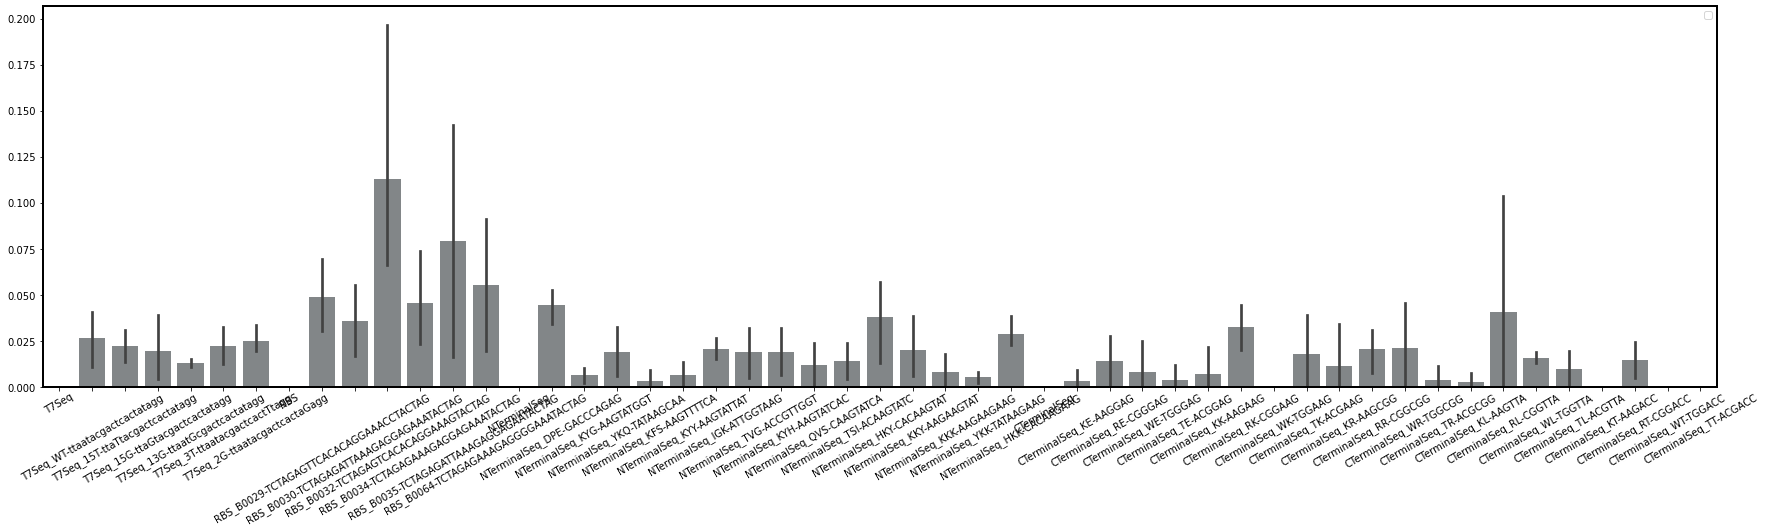

In [ ]:
import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 1.0 #set the value globally

fig, ax = plt.subplots()

ax = sns.barplot(data=importance_df, color='#818689')
#ax = sns.barplot(data=importance_df.iloc[[len(importance_df)-1]], color='#818689')
#ax = plt.plot(list(importance_df.iloc[[len(importance_df)-1]].values[0]), marker='o', markersize=10, ls='', color='#F2B342', label='Last Round')

fig.set_size_inches(30, 7)
plt.legend()
plt.xticks(rotation=30)

In [ ]:
#fig.savefig('importance_df.png', format='png', dpi=1200)
fig.savefig('importance_df.svg', format='svg', dpi=1200)

# Find NonLinear Interactions

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download Interactions.png from Files</p1>

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

,T7Seq,T7Seq_WT-ttaatacgactcactatagg,T7Seq_15T-ttaTtacgactcactatagg,T7Seq_15G-ttaGtacgactcactatagg,T7Seq_13G-ttaatGcgactcactatagg,T7Seq_3T-ttaatacgactcactTtagg,T7Seq_2G-ttaatacgactcactaGagg,RBS,RBS_B0029-TCTAGAGTTCACACAGGAAACCTACTAG,RBS_B0030-TCTAGAGATTAAAGAGGAGAAATACTAG,RBS_B0032-TCTAGAGTCACACAGGAAAGTACTAG,RBS_B0034-TCTAGAGAAAGAGGAGAAATACTAG,RBS_B0035-TCTAGAGATTAAAGAGGAGAATACTAG,RBS_B0064-TCTAGAGAAAGAGGGGAAATACTAG,NTerminalSeq,NTerminalSeq_DPE-GACCCAGAG,NTerminalSeq_KYG-AAGTATGGT,NTerminalSeq_YKQ-TATAAGCAA,NTerminalSeq_KFS-AAGTTTTCA,NTerminalSeq_KYY-AAGTATTAT,NTerminalSeq_IGK-ATTGGTAAG,NTerminalSeq_TVG-ACCGTTGGT,NTerminalSeq_KYH-AAGTATCAC,NTerminalSeq_QVS-CAAGTATCA,NTerminalSeq_TSI-ACAAGTATC,NTerminalSeq_HKY-CACAAGTAT,NTerminalSeq_KKY-AAGAAGTAT,NTerminalSeq_KKK-AAGAAGAAG,NTerminalSeq_YKK-TATAAGAAG,NTerminalSeq_HKK-CACAAGAAG,CTerminalSeq,CTerminalSeq_KE-AAGGAG,CTerminalSeq_RE-CGGGAG,CTerminalSeq_WE-TGGGAG,CTerminalSeq_TE-ACGGAG,CTerminalSeq_KK-AAGAAG,CTerminalSeq_RK-CGGAAG,CTerminalSeq_WK-TGGAAG,CTerminalSeq_TK-ACGAAG,CTerminalSeq_KR-AAGCGG,CTerminalSeq_RR-CGGCGG,CTerminalSeq_WR-TGGCGG,CTerminalSeq_TR-ACGCGG,CTerminalSeq_KL-AAGTTA,CTerminalSeq_RL-CGGTTA,CTerminalSeq_WL-TGGTTA,CTerminalSeq_TL-ACGTTA,CTerminalSeq_KT-AAGACC,CTerminalSeq_RT-CGGACC,CTerminalSeq_WT-TGGACC,CTerminalSeq_TT-ACGACC
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
196,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
197,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
198,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.linear_model import LinearRegression
from itertools import combinations

model = LinearRegression()
model.fit(aggregated_data_m.values, aggregated_label_m.values)
baseline_score = pearsonr(pd.DataFrame(model.predict(aggregated_data_m.values))[0] ,aggregated_label_m['yield'])
baseline_score

(0.8184157726014416, 1.5753643175806682e-49)

In [ ]:
interaction_scores = {}
for i in combinations(aggregated_data_m.columns, 2):
    X = pd.concat([aggregated_data_m, (aggregated_data_m[i[0]] * aggregated_data_m[i[1]])], axis=1)
    y = aggregated_label_m

    model = LinearRegression()
    model.fit(X.values, y.values)
    score = pearsonr(pd.DataFrame(model.predict(X.values))[0] ,y['yield'])

    interaction_scores[i] = score

In [ ]:
interactions_df = pd.DataFrame(data=np.zeros([len(aggregated_data_m.columns), len(aggregated_data_m.columns)]), columns=aggregated_data_m.columns, index=aggregated_data_m.columns)

for columns, value in interaction_scores.items():
    diff = value[0] - baseline_score[0]
    interactions_df[columns[0]][columns[1]] = diff

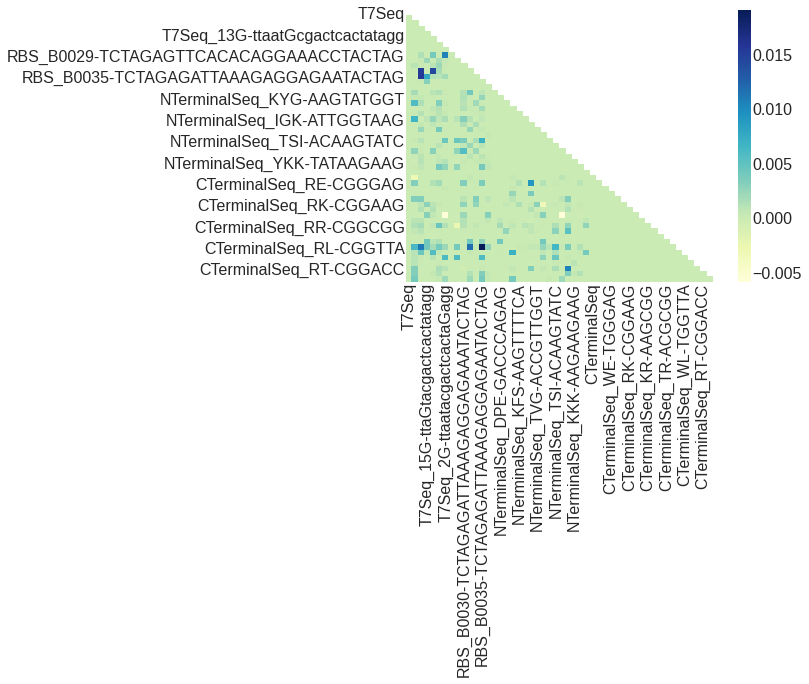

In [ ]:
corr = np.corrcoef(np.random.randn(len(aggregated_data_m.columns), 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (7,5))
ax = sns.heatmap(interactions_df, mask=mask, cmap='YlGnBu')

In [ ]:
fig.savefig('Interactions.png', format='png', dpi=1200)
fig.savefig('Interactions.svg', format='svg', dpi=1200)

In [ ]:
interactions_df.to_csv('Interactions.csv')